In [1]:
from matplotlib import animation
from pprint import pprint
import ray
%matplotlib notebook

from run import *

In [2]:
def run_evaluation(
    agent_run_names, 
    agent_checkpoints, 
    config, 
    policy_name="ppo", 
    seed=1,
    heterogeneous=True,
    num_episodes=1,
    record=True
):
    ray.shutdown()
    ray.init()
    eval_run_name = ""
    for i in range(len(agent_run_names)):
        eval_run_name += f"{agent_run_names[i]}_{agent_checkpoints[i]}_"
    eval_run_name = eval_run_name[:-1]
    ray_dir = f"{os.path.expanduser('~')}/ray_results"
    eval_results_dir = f"{ray_dir}/{eval_run_name}"
    register_env("ZSC-Cleaner", lambda _: CleanerEnv(config["env_config"], run_name=eval_run_name))

    agents = {}
    for i in range(config["env_config"]["num_agents"]):
        agent = Agent(
            policy_name=policy_name,
            run_name=agent_run_names[i],
            agent_num=i,
            config=config,
            seed=seed,
            heterogeneous=heterogeneous,
        )
        agents[agent.name] = agent
        trainer_agents = {}
        for other_agent_num in range(agent.config["env_config"]["num_agents"]):
            other_agent = deepcopy(agent)
            other_agent.agent_num = other_agent_num
            other_agent.name = f"{agent.run_name}:{other_agent_num}"
            trainer_agents[other_agent.name] = other_agent
        agent.trainer = create_trainer(
            agent.policy_name,
            trainer_agents, 
            agent.config, 
            agent.results_dir, 
            seed=agent.seed, 
            heterogeneous=agent.heterogeneous, 
            num_workers=1
        )
        checkpoint_num = agent_checkpoints[i]
        checkpoint_path = f"{ray_dir}/{agent.run_name}/checkpoint_" \
                          f"{str(checkpoint_num).zfill(6)}/checkpoint-{checkpoint_num}"
        agent.trainer.load_checkpoint(checkpoint_path)
    
    ep_rewards, ani = evaluate(
        agents,
        config,
        eval_run_name,
        heterogeneous=heterogeneous,
        num_episodes=num_episodes,
        record=record,
    )
    return ep_rewards, ani

In [3]:
def cross_play(
    run_name_0, run_name_1, checkpoint_0, checkpoint_1, config,
    heterogeneous=True, num_episodes=1
):
    num_agents = config["env_config"]["num_agents"]
    self_play_0, _ = run_evaluation(
        [run_name_0] * num_agents, 
        [checkpoint_0] * num_agents, 
        config, 
        policy_name="ppo", 
        seed=1,
        heterogeneous=heterogeneous,
        num_episodes=num_episodes,
        record=False
    )
    self_play_1, _ = run_evaluation(
        [run_name_1] * num_agents, 
        [checkpoint_1] * num_agents, 
        config, 
        policy_name="ppo", 
        seed=1,
        heterogeneous=heterogeneous,
        num_episodes=num_episodes,
        record=False
    )
    if num_agents == 2:
        run_names = [run_name_0, run_name_1]
        checkpoints = [checkpoint_0, checkpoint_1]
    elif num_agents == 4:
        run_names = [run_name_0, run_name_1, run_name_1, run_name_0]
        checkpoints = [checkpoint_0, checkpoint_1, checkpoint_1, checkpoint_0]
    elif num_agents == 5:
        run_names = [run_name_0, run_name_1, run_name_0, run_name_1, run_name_0]
        checkpoints = [checkpoint_0, checkpoint_1, checkpoint_0, checkpoint_1, checkpoint_0]
    elif num_agents == 8:
        run_names = [run_name_0, run_name_1, run_name_1, run_name_0, 
                     run_name_1, run_name_0, run_name_0, run_name_1]
        checkpoints = [checkpoint_0, checkpoint_1, checkpoint_1, checkpoint_0,
                       checkpoint_1, checkpoint_0, checkpoint_0, checkpoint_1]
    cross_play, _ = run_evaluation(
        run_names,
        checkpoints,
        config, 
        policy_name="ppo", 
        seed=1,
        heterogeneous=heterogeneous,
        num_episodes=num_episodes,
        record=False
    )
    return self_play_0, self_play_1, cross_play

2021-08-25 21:27:13,280	INFO services.py:1272 -- View the Ray dashboard at http://127.0.0.1:8265
2021-08-25 21:27:17,271	WARNING util.py:53 -- Install gputil for GPU system monitoring.
2021-08-25 21:27:20,091	WARNING util.py:53 -- Install gputil for GPU system monitoring.


<IPython.core.display.Javascript object>


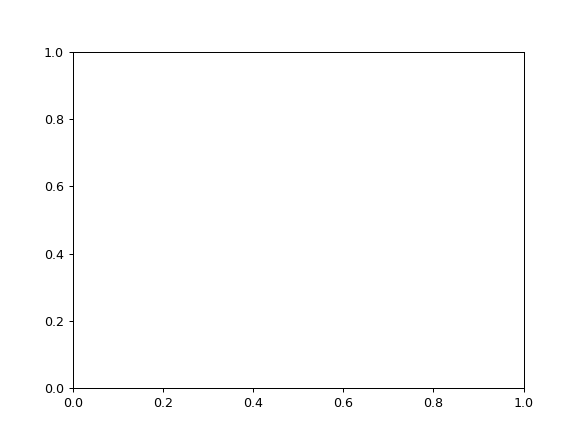

episode rewards: [29.0, 34.0, 27.0, 35.0, 28.0, 39.0, 30.0, 32.0, 35.0, 35.0, 41.0, 28.0, 23.0, 30.0, 33.0, 38.0, 25.0, 18.0, 41.0, 20.0, 31.0, 32.0, 32.0, 26.0, 26.0, 43.0, 31.0, 37.0, 37.0, 41.0, 37.0, 19.0, 32.0, 26.0, 33.0, 32.0, 31.0, 29.0, 39.0, 28.0, 40.0, 40.0, 33.0, 33.0, 29.0, 24.0, 30.0, 39.0, 41.0, 18.0] (mean = 31.8)


2021-08-25 21:27:37,019	INFO services.py:1272 -- View the Ray dashboard at http://127.0.0.1:8265
2021-08-25 21:27:40,733	WARNING util.py:53 -- Install gputil for GPU system monitoring.
2021-08-25 21:27:43,417	WARNING util.py:53 -- Install gputil for GPU system monitoring.


<IPython.core.display.Javascript object>


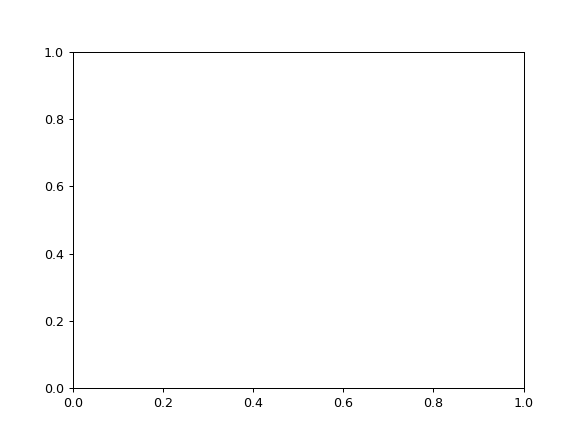

episode rewards: [36.0, 43.0, 37.0, 21.0, 29.0, 29.0, 31.0, 39.0, 27.0, 35.0, 40.0, 24.0, 27.0, 38.0, 37.0, 33.0, 14.0, 35.0, 30.0, 35.0, 30.0, 18.0, 19.0, 19.0, 29.0, 40.0, 25.0, 35.0, 22.0, 25.0, 18.0, 32.0, 26.0, 38.0, 23.0, 39.0, 12.0, 33.0, 38.0, 30.0, 36.0, 43.0, 33.0, 31.0, 26.0, 50.0, 36.0, 43.0, 42.0, 17.0] (mean = 30.96)


2021-08-25 21:28:00,684	INFO services.py:1272 -- View the Ray dashboard at http://127.0.0.1:8265
2021-08-25 21:28:04,232	WARNING util.py:53 -- Install gputil for GPU system monitoring.
2021-08-25 21:28:06,921	WARNING util.py:53 -- Install gputil for GPU system monitoring.


<IPython.core.display.Javascript object>


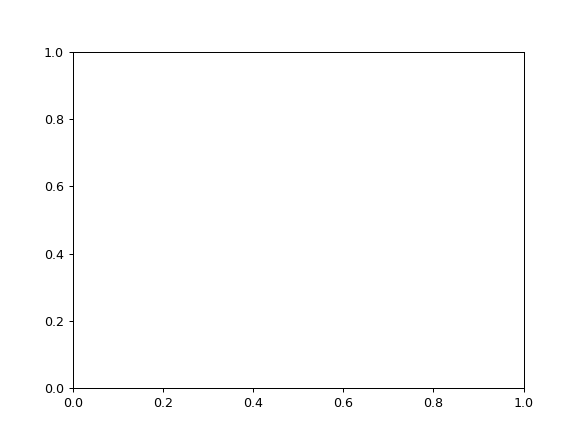

episode rewards: [36.0, 30.0, 41.0, 32.0, 30.0, 32.0, 26.0, 33.0, 31.0, 29.0, 29.0, 47.0, 26.0, 43.0, 35.0, 29.0, 21.0, 15.0, 38.0, 40.0, 28.0, 25.0, 28.0, 31.0, 32.0, 25.0, 23.0, 49.0, 33.0, 14.0, 33.0, 34.0, 23.0, 34.0, 31.0, 27.0, 23.0, 27.0, 38.0, 33.0, 39.0, 34.0, 31.0, 39.0, 24.0, 22.0, 29.0, 48.0, 34.0, 17.0] (mean = 31.02)


2021-08-25 21:28:25,106	INFO services.py:1272 -- View the Ray dashboard at http://127.0.0.1:8265
2021-08-25 21:28:28,766	WARNING util.py:53 -- Install gputil for GPU system monitoring.
2021-08-25 21:28:31,442	WARNING util.py:53 -- Install gputil for GPU system monitoring.


<IPython.core.display.Javascript object>


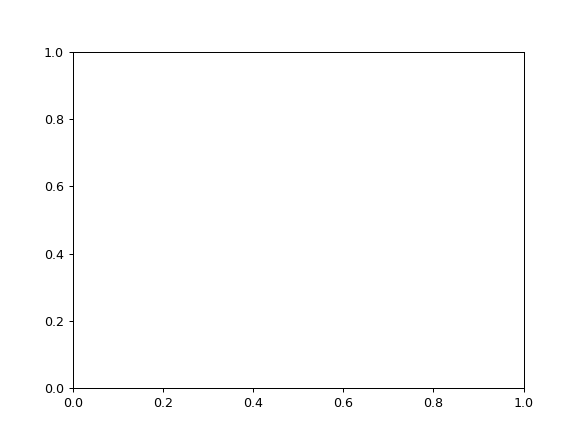

episode rewards: [50.0, 47.0, 34.0, 30.0, 51.0, 37.0, 42.0, 45.0, 48.0, 35.0, 43.0, 48.0, 28.0, 47.0, 39.0, 44.0, 45.0, 47.0, 45.0, 45.0, 44.0, 46.0, 45.0, 30.0, 36.0, 43.0, 51.0, 35.0, 47.0, 45.0, 46.0, 15.0, 18.0, 54.0, 43.0, 51.0, 57.0, 50.0, 49.0, 41.0, 31.0, 60.0, 26.0, 52.0, 62.0, 63.0, 32.0, 26.0, 52.0, 41.0] (mean = 42.82)


2021-08-25 21:28:48,028	INFO services.py:1272 -- View the Ray dashboard at http://127.0.0.1:8265
2021-08-25 21:28:51,647	WARNING util.py:53 -- Install gputil for GPU system monitoring.
2021-08-25 21:28:54,301	WARNING util.py:53 -- Install gputil for GPU system monitoring.


<IPython.core.display.Javascript object>


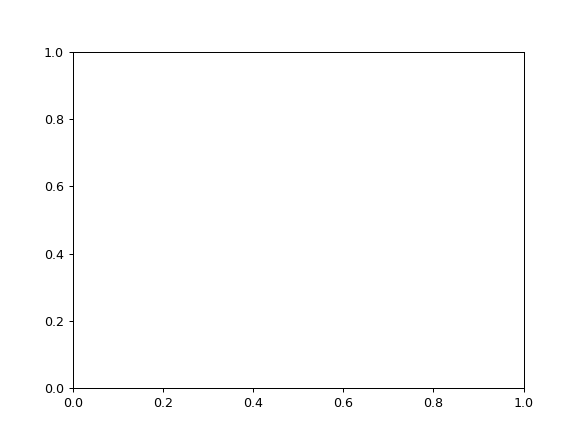

episode rewards: [39.0, 21.0, 46.0, 28.0, 44.0, 47.0, 50.0, 50.0, 49.0, 36.0, 35.0, 44.0, 44.0, 38.0, 34.0, 47.0, 37.0, 30.0, 43.0, 51.0, 55.0, 48.0, 52.0, 57.0, 35.0, 48.0, 44.0, 28.0, 42.0, 49.0, 46.0, 48.0, 36.0, 50.0, 38.0, 49.0, 43.0, 41.0, 30.0, 45.0, 41.0, 33.0, 51.0, 39.0, 44.0, 36.0, 44.0, 49.0, 51.0, 45.0] (mean = 42.6)


2021-08-25 21:29:10,357	INFO services.py:1272 -- View the Ray dashboard at http://127.0.0.1:8265
2021-08-25 21:29:15,034	WARNING util.py:53 -- Install gputil for GPU system monitoring.
2021-08-25 21:29:17,662	WARNING util.py:53 -- Install gputil for GPU system monitoring.


<IPython.core.display.Javascript object>


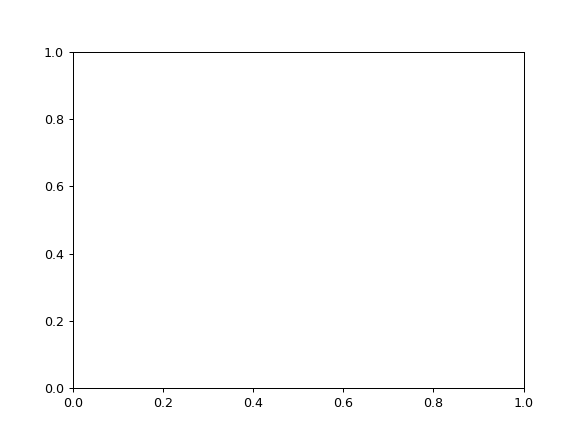

episode rewards: [39.0, 37.0, 46.0, 34.0, 32.0, 46.0, 45.0, 49.0, 42.0, 39.0, 47.0, 53.0, 48.0, 53.0, 33.0, 24.0, 33.0, 35.0, 40.0, 28.0, 27.0, 42.0, 23.0, 33.0, 24.0, 33.0, 29.0, 21.0, 42.0, 44.0, 18.0, 47.0, 36.0, 22.0, 18.0, 47.0, 32.0, 44.0, 35.0, 44.0, 27.0, 32.0, 43.0, 26.0, 37.0, 37.0, 33.0, 23.0, 37.0, 35.0] (mean = 35.88)


2021-08-25 21:29:34,805	INFO services.py:1272 -- View the Ray dashboard at http://127.0.0.1:8265
2021-08-25 21:29:38,615	WARNING util.py:53 -- Install gputil for GPU system monitoring.
2021-08-25 21:29:41,411	WARNING util.py:53 -- Install gputil for GPU system monitoring.


<IPython.core.display.Javascript object>


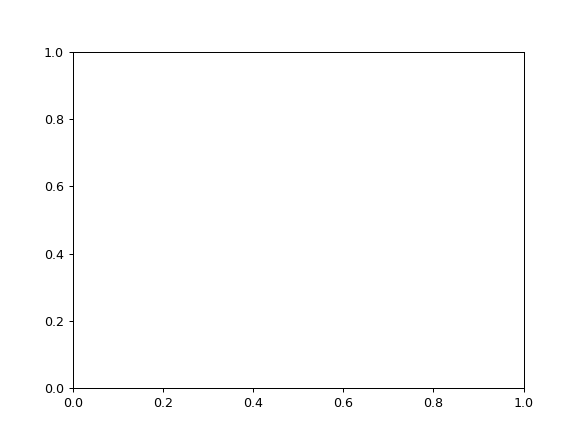

episode rewards: [59.0, 40.0, 40.0, 45.0, 46.0, 50.0, 56.0, 40.0, 47.0, 53.0, 42.0, 33.0, 39.0, 35.0, 48.0, 51.0, 40.0, 43.0, 45.0, 42.0, 44.0, 60.0, 44.0, 35.0, 53.0, 25.0, 41.0, 11.0, 37.0, 43.0, 50.0, 37.0, 49.0, 21.0, 45.0, 42.0, 55.0, 46.0, 30.0, 34.0, 60.0, 39.0, 54.0, 27.0, 40.0, 56.0, 36.0, 37.0, 37.0, 38.0] (mean = 42.4)


2021-08-25 21:29:58,817	INFO services.py:1272 -- View the Ray dashboard at http://127.0.0.1:8265
2021-08-25 21:30:02,600	WARNING util.py:53 -- Install gputil for GPU system monitoring.
2021-08-25 21:30:05,339	WARNING util.py:53 -- Install gputil for GPU system monitoring.


<IPython.core.display.Javascript object>


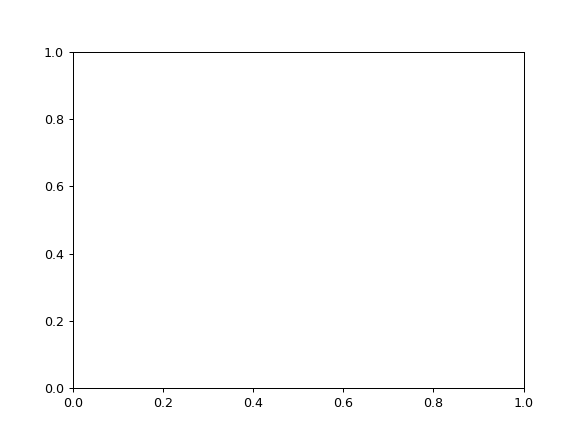

episode rewards: [52.0, 31.0, 55.0, 51.0, 52.0, 38.0, 63.0, 38.0, 48.0, 56.0, 50.0, 45.0, 40.0, 40.0, 32.0, 46.0, 40.0, 35.0, 37.0, 39.0, 39.0, 62.0, 35.0, 43.0, 44.0, 43.0, 26.0, 52.0, 35.0, 47.0, 42.0, 32.0, 50.0, 52.0, 54.0, 52.0, 48.0, 47.0, 42.0, 49.0, 41.0, 52.0, 48.0, 49.0, 43.0, 43.0, 53.0, 48.0, 43.0, 40.0] (mean = 44.84)


2021-08-25 21:30:23,772	INFO services.py:1272 -- View the Ray dashboard at http://127.0.0.1:8265
2021-08-25 21:30:27,505	WARNING util.py:53 -- Install gputil for GPU system monitoring.
2021-08-25 21:30:30,221	WARNING util.py:53 -- Install gputil for GPU system monitoring.


<IPython.core.display.Javascript object>


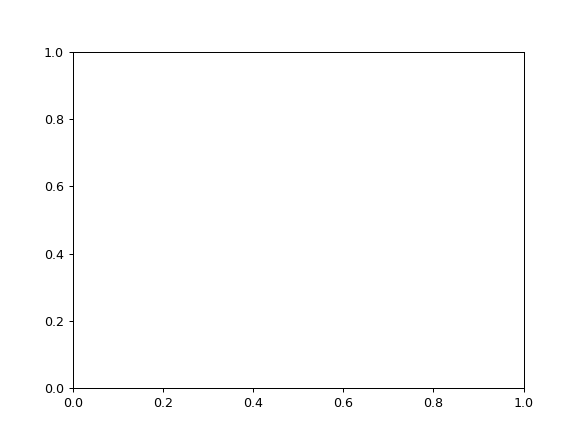

episode rewards: [43.0, 29.0, 23.0, 26.0, 36.0, 26.0, 31.0, 31.0, 50.0, 41.0, 29.0, 38.0, 39.0, 47.0, 44.0, 50.0, 45.0, 52.0, 54.0, 40.0, 25.0, 45.0, 44.0, 27.0, 32.0, 20.0, 52.0, 27.0, 14.0, 32.0, 37.0, 32.0, 49.0, 25.0, 33.0, 35.0, 35.0, 24.0, 44.0, 42.0, 29.0, 26.0, 45.0, 16.0, 48.0, 48.0, 33.0, 33.0, 34.0, 22.0] (mean = 35.64)


2021-08-25 21:30:47,115	INFO services.py:1272 -- View the Ray dashboard at http://127.0.0.1:8265
2021-08-25 21:30:50,915	WARNING util.py:53 -- Install gputil for GPU system monitoring.
2021-08-25 21:30:53,651	WARNING util.py:53 -- Install gputil for GPU system monitoring.


<IPython.core.display.Javascript object>


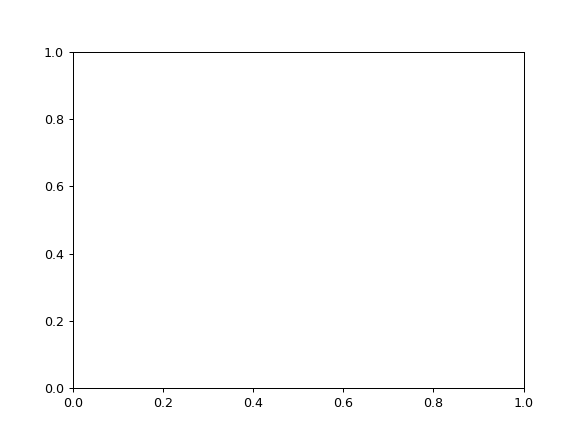

episode rewards: [53.0, 55.0, 47.0, 47.0, 48.0, 33.0, 25.0, 49.0, 67.0, 50.0, 50.0, 51.0, 46.0, 52.0, 32.0, 58.0, 59.0, 43.0, 41.0, 46.0, 49.0, 45.0, 56.0, 44.0, 57.0, 52.0, 47.0, 54.0, 47.0, 57.0, 51.0, 57.0, 64.0, 39.0, 56.0, 58.0, 44.0, 64.0, 50.0, 57.0, 55.0, 20.0, 52.0, 44.0, 57.0, 50.0, 57.0, 34.0, 43.0, 42.0] (mean = 49.08)


2021-08-25 21:31:10,845	INFO services.py:1272 -- View the Ray dashboard at http://127.0.0.1:8265
2021-08-25 21:31:14,592	WARNING util.py:53 -- Install gputil for GPU system monitoring.
2021-08-25 21:31:17,336	WARNING util.py:53 -- Install gputil for GPU system monitoring.


<IPython.core.display.Javascript object>


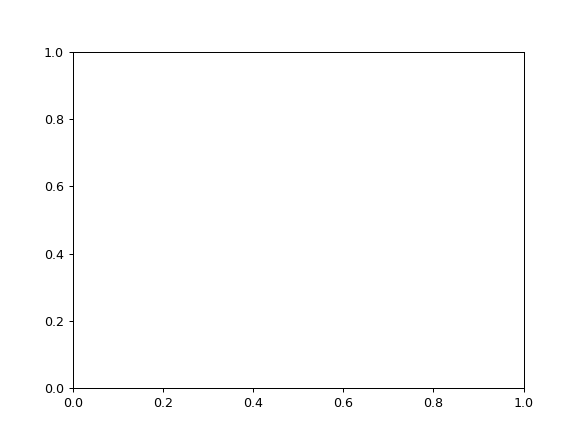

episode rewards: [49.0, 49.0, 36.0, 38.0, 57.0, 48.0, 59.0, 53.0, 49.0, 55.0, 53.0, 44.0, 51.0, 58.0, 43.0, 35.0, 38.0, 49.0, 41.0, 44.0, 50.0, 67.0, 36.0, 55.0, 41.0, 41.0, 49.0, 47.0, 52.0, 45.0, 49.0, 43.0, 53.0, 58.0, 52.0, 43.0, 46.0, 45.0, 57.0, 35.0, 50.0, 55.0, 43.0, 43.0, 60.0, 43.0, 51.0, 49.0, 59.0, 58.0] (mean = 48.48)


2021-08-25 21:31:35,649	INFO services.py:1272 -- View the Ray dashboard at http://127.0.0.1:8265
2021-08-25 21:31:39,296	WARNING util.py:53 -- Install gputil for GPU system monitoring.
2021-08-25 21:31:42,040	WARNING util.py:53 -- Install gputil for GPU system monitoring.


<IPython.core.display.Javascript object>


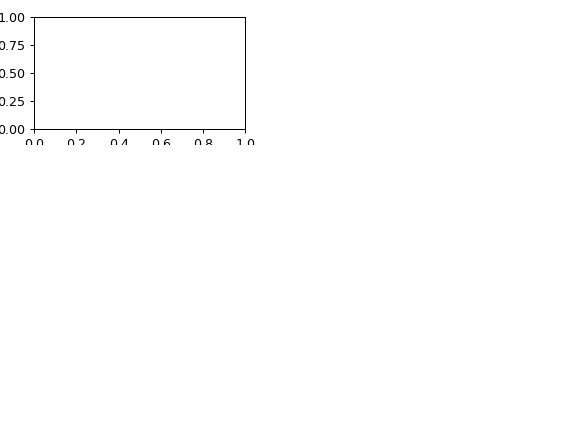

episode rewards: [37.0, 37.0, 46.0, 29.0, 45.0, 47.0, 31.0, 40.0, 23.0, 41.0, 30.0, 28.0, 40.0, 25.0, 35.0, 37.0, 17.0, 37.0, 33.0, 32.0, 40.0, 25.0, 44.0, 30.0, 44.0, 27.0, 37.0, 48.0, 31.0, 15.0, 20.0, 47.0, 38.0, 39.0, 34.0, 43.0, 40.0, 29.0, 40.0, 48.0, 51.0, 49.0, 43.0, 27.0, 46.0, 39.0, 32.0, 36.0, 40.0, 27.0] (mean = 35.98)


2021-08-25 21:31:58,806	INFO services.py:1272 -- View the Ray dashboard at http://127.0.0.1:8265
2021-08-25 21:32:02,620	WARNING util.py:53 -- Install gputil for GPU system monitoring.
2021-08-25 21:32:05,368	WARNING util.py:53 -- Install gputil for GPU system monitoring.


<IPython.core.display.Javascript object>


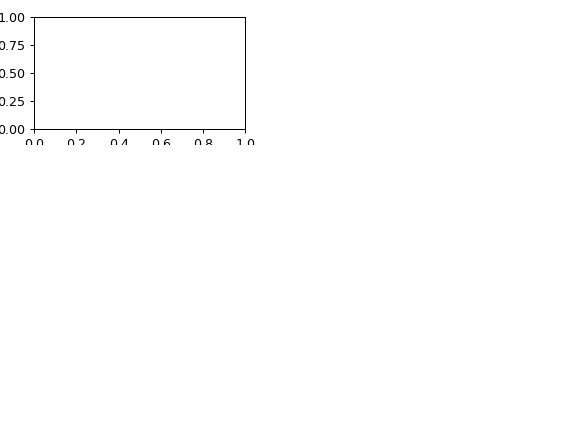

episode rewards: [45.0, 65.0, 36.0, 57.0, 34.0, 38.0, 42.0, 41.0, 55.0, 60.0, 52.0, 50.0, 67.0, 48.0, 54.0, 54.0, 48.0, 38.0, 46.0, 55.0, 55.0, 58.0, 38.0, 46.0, 64.0, 74.0, 46.0, 59.0, 58.0, 52.0, 43.0, 50.0, 56.0, 47.0, 51.0, 59.0, 63.0, 43.0, 58.0, 53.0, 59.0, 20.0, 47.0, 49.0, 36.0, 28.0, 47.0, 53.0, 58.0, 71.0] (mean = 50.52)


2021-08-25 21:32:22,212	INFO services.py:1272 -- View the Ray dashboard at http://127.0.0.1:8265
2021-08-25 21:32:25,983	WARNING util.py:53 -- Install gputil for GPU system monitoring.
2021-08-25 21:32:28,731	WARNING util.py:53 -- Install gputil for GPU system monitoring.


<IPython.core.display.Javascript object>


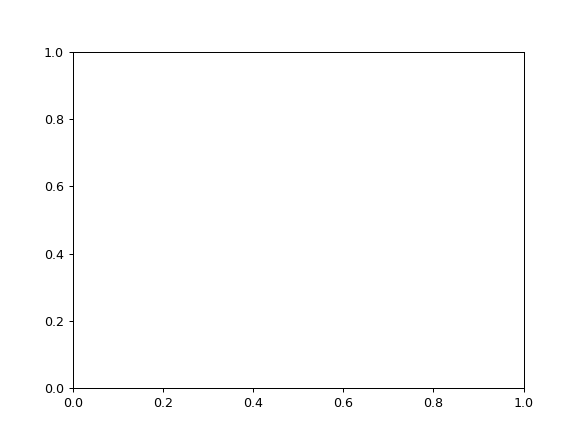

episode rewards: [52.0, 41.0, 54.0, 52.0, 49.0, 54.0, 52.0, 45.0, 45.0, 53.0, 24.0, 44.0, 52.0, 47.0, 42.0, 23.0, 47.0, 61.0, 64.0, 52.0, 44.0, 41.0, 41.0, 52.0, 21.0, 51.0, 46.0, 45.0, 58.0, 44.0, 52.0, 42.0, 39.0, 56.0, 55.0, 51.0, 43.0, 58.0, 56.0, 46.0, 50.0, 61.0, 50.0, 50.0, 59.0, 46.0, 51.0, 46.0, 55.0, 61.0] (mean = 48.46)


2021-08-25 21:32:47,219	INFO services.py:1272 -- View the Ray dashboard at http://127.0.0.1:8265
2021-08-25 21:32:50,952	WARNING util.py:53 -- Install gputil for GPU system monitoring.
2021-08-25 21:32:53,696	WARNING util.py:53 -- Install gputil for GPU system monitoring.


<IPython.core.display.Javascript object>


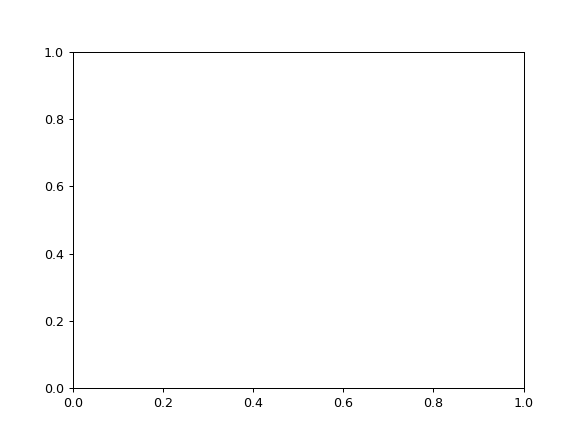

episode rewards: [43.0, 34.0, 31.0, 11.0, 29.0, 17.0, 46.0, 37.0, 56.0, 33.0, 11.0, 41.0, 37.0, 27.0, 30.0, 31.0, 36.0, 26.0, 45.0, 38.0, 31.0, 17.0, 16.0, 39.0, 37.0, 30.0, 51.0, 27.0, 29.0, 38.0, 23.0, 29.0, 26.0, 38.0, 48.0, 40.0, 42.0, 45.0, 32.0, 31.0, 14.0, 29.0, 21.0, 14.0, 29.0, 30.0, 14.0, 27.0, 30.0, 37.0] (mean = 31.46)


2021-08-25 21:33:10,780	INFO services.py:1272 -- View the Ray dashboard at http://127.0.0.1:8265
2021-08-25 21:33:14,579	WARNING util.py:53 -- Install gputil for GPU system monitoring.
2021-08-25 21:33:17,317	WARNING util.py:53 -- Install gputil for GPU system monitoring.


<IPython.core.display.Javascript object>


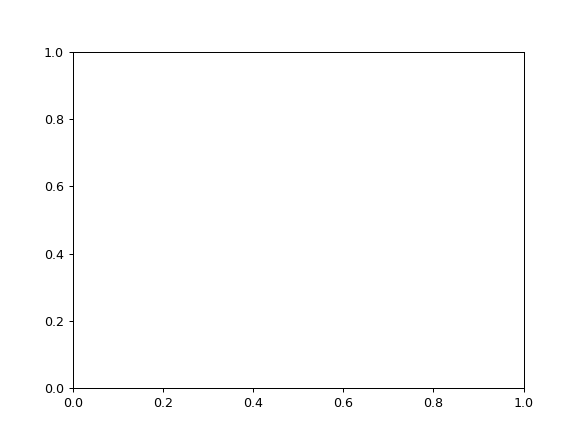

episode rewards: [57.0, 47.0, 59.0, 40.0, 55.0, 58.0, 55.0, 56.0, 63.0, 61.0, 56.0, 67.0, 63.0, 60.0, 51.0, 54.0, 60.0, 52.0, 56.0, 60.0, 58.0, 71.0, 62.0, 45.0, 56.0, 52.0, 40.0, 54.0, 42.0, 55.0, 63.0, 59.0, 62.0, 59.0, 58.0, 59.0, 60.0, 47.0, 56.0, 57.0, 65.0, 57.0, 42.0, 57.0, 54.0, 60.0, 63.0, 53.0, 73.0, 47.0] (mean = 56.32)


2021-08-25 21:33:33,981	INFO services.py:1272 -- View the Ray dashboard at http://127.0.0.1:8265
2021-08-25 21:33:39,076	WARNING util.py:53 -- Install gputil for GPU system monitoring.
2021-08-25 21:33:41,817	WARNING util.py:53 -- Install gputil for GPU system monitoring.


<IPython.core.display.Javascript object>


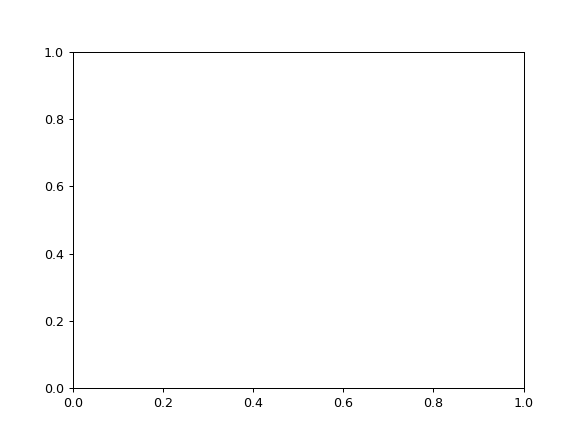

episode rewards: [52.0, 54.0, 69.0, 48.0, 33.0, 57.0, 54.0, 65.0, 48.0, 64.0, 51.0, 44.0, 53.0, 42.0, 50.0, 48.0, 47.0, 56.0, 65.0, 51.0, 56.0, 61.0, 62.0, 33.0, 46.0, 54.0, 58.0, 43.0, 50.0, 43.0, 60.0, 41.0, 54.0, 44.0, 55.0, 48.0, 60.0, 60.0, 63.0, 50.0, 59.0, 53.0, 57.0, 41.0, 56.0, 58.0, 49.0, 54.0, 49.0, 48.0] (mean = 52.32)


2021-08-25 21:34:00,975	INFO services.py:1272 -- View the Ray dashboard at http://127.0.0.1:8265
2021-08-25 21:34:04,798	WARNING util.py:53 -- Install gputil for GPU system monitoring.
2021-08-25 21:34:07,546	WARNING util.py:53 -- Install gputil for GPU system monitoring.


<IPython.core.display.Javascript object>


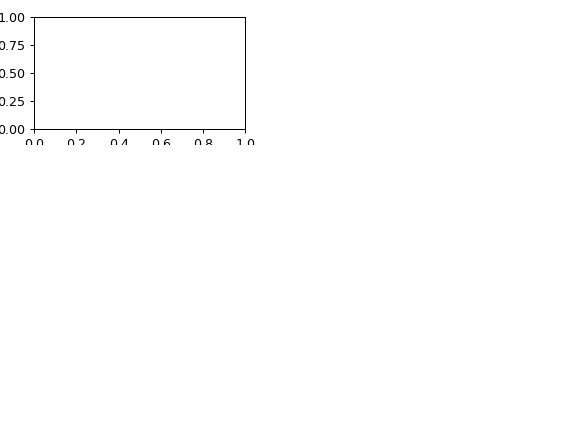

episode rewards: [29.0, 29.0, 32.0, 15.0, 49.0, 26.0, 31.0, 49.0, 51.0, 49.0, 31.0, 38.0, 41.0, 28.0, 14.0, 39.0, 44.0, 15.0, 34.0, 36.0, 44.0, 31.0, 14.0, 41.0, 19.0, 22.0, 42.0, 40.0, 44.0, 45.0, 27.0, 28.0, 47.0, 17.0, 46.0, 45.0, 24.0, 16.0, 39.0, 43.0, 19.0, 56.0, 38.0, 23.0, 51.0, 10.0, 34.0, 24.0, 47.0, 16.0] (mean = 33.44)


2021-08-25 21:34:25,052	INFO services.py:1272 -- View the Ray dashboard at http://127.0.0.1:8265
2021-08-25 21:34:28,908	WARNING util.py:53 -- Install gputil for GPU system monitoring.
2021-08-25 21:34:31,670	WARNING util.py:53 -- Install gputil for GPU system monitoring.


<IPython.core.display.Javascript object>


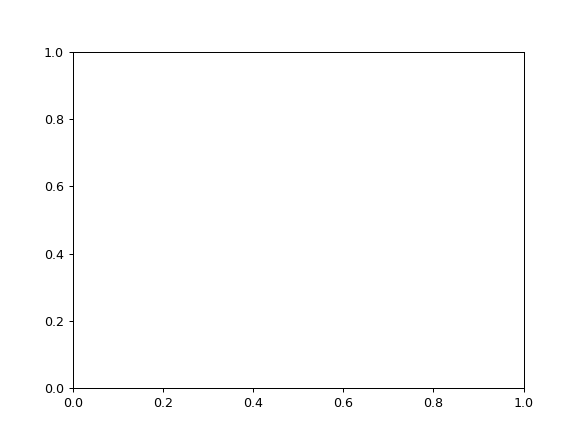

episode rewards: [64.0, 57.0, 49.0, 60.0, 45.0, 43.0, 64.0, 59.0, 60.0, 54.0, 63.0, 67.0, 56.0, 61.0, 51.0, 52.0, 61.0, 54.0, 52.0, 64.0, 64.0, 64.0, 60.0, 58.0, 64.0, 59.0, 71.0, 63.0, 70.0, 38.0, 52.0, 58.0, 45.0, 55.0, 61.0, 63.0, 59.0, 67.0, 61.0, 67.0, 55.0, 62.0, 62.0, 52.0, 59.0, 61.0, 65.0, 63.0, 59.0, 36.0] (mean = 58.18)


2021-08-25 21:34:51,014	INFO services.py:1272 -- View the Ray dashboard at http://127.0.0.1:8265
2021-08-25 21:34:54,830	WARNING util.py:53 -- Install gputil for GPU system monitoring.
2021-08-25 21:34:57,619	WARNING util.py:53 -- Install gputil for GPU system monitoring.


<IPython.core.display.Javascript object>


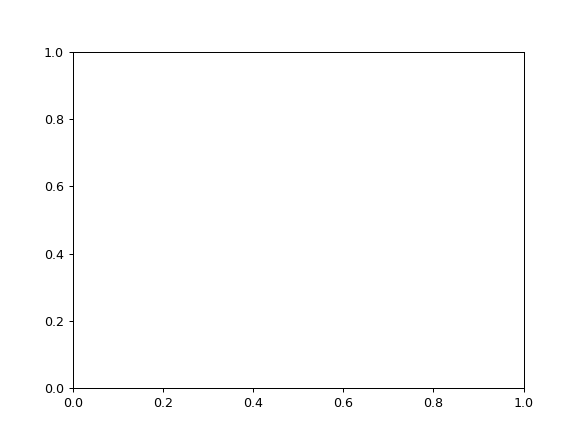

episode rewards: [61.0, 62.0, 63.0, 39.0, 53.0, 65.0, 52.0, 67.0, 53.0, 62.0, 47.0, 50.0, 41.0, 51.0, 47.0, 69.0, 58.0, 60.0, 54.0, 40.0, 63.0, 65.0, 40.0, 58.0, 67.0, 66.0, 59.0, 59.0, 61.0, 53.0, 57.0, 57.0, 57.0, 70.0, 57.0, 55.0, 44.0, 54.0, 51.0, 35.0, 38.0, 59.0, 69.0, 24.0, 64.0, 49.0, 68.0, 53.0, 57.0, 51.0] (mean = 55.08)


2021-08-25 21:35:15,225	INFO services.py:1272 -- View the Ray dashboard at http://127.0.0.1:8265
2021-08-25 21:35:19,015	WARNING util.py:53 -- Install gputil for GPU system monitoring.
2021-08-25 21:35:21,752	WARNING util.py:53 -- Install gputil for GPU system monitoring.


<IPython.core.display.Javascript object>


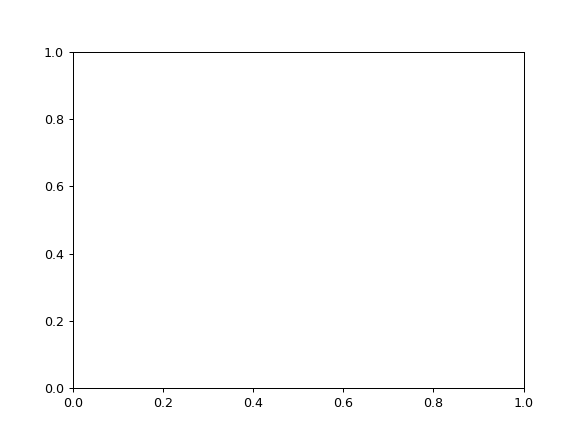

episode rewards: [23.0, 47.0, 38.0, 39.0, 60.0, 40.0, 34.0, 50.0, 60.0, 27.0, 36.0, 35.0, 39.0, 51.0, 40.0, 15.0, 48.0, 19.0, 28.0, 48.0, 34.0, 44.0, 51.0, 33.0, 56.0, 24.0, 41.0, 32.0, 39.0, 49.0, 15.0, 13.0, 19.0, 39.0, 43.0, 49.0, 22.0, 34.0, 54.0, 32.0, 27.0, 53.0, 29.0, 63.0, 48.0, 32.0, 51.0, 41.0, 51.0, 23.0] (mean = 38.36)


2021-08-25 21:35:39,223	INFO services.py:1272 -- View the Ray dashboard at http://127.0.0.1:8265
2021-08-25 21:35:43,095	WARNING util.py:53 -- Install gputil for GPU system monitoring.
2021-08-25 21:35:45,863	WARNING util.py:53 -- Install gputil for GPU system monitoring.


<IPython.core.display.Javascript object>


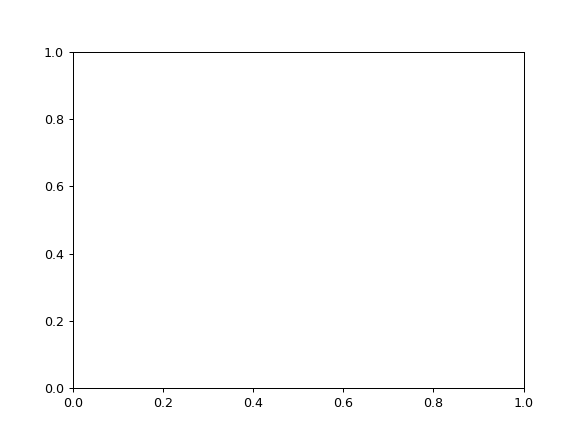

episode rewards: [63.0, 57.0, 53.0, 69.0, 73.0, 60.0, 58.0, 46.0, 48.0, 52.0, 64.0, 60.0, 47.0, 60.0, 69.0, 51.0, 58.0, 72.0, 45.0, 60.0, 67.0, 67.0, 58.0, 53.0, 69.0, 63.0, 69.0, 53.0, 65.0, 69.0, 62.0, 66.0, 50.0, 60.0, 68.0, 67.0, 65.0, 69.0, 76.0, 68.0, 56.0, 70.0, 32.0, 67.0, 73.0, 66.0, 51.0, 64.0, 64.0, 67.0] (mean = 61.18)


2021-08-25 21:36:04,661	INFO services.py:1272 -- View the Ray dashboard at http://127.0.0.1:8265
2021-08-25 21:36:08,472	WARNING util.py:53 -- Install gputil for GPU system monitoring.
2021-08-25 21:36:11,195	WARNING util.py:53 -- Install gputil for GPU system monitoring.


<IPython.core.display.Javascript object>


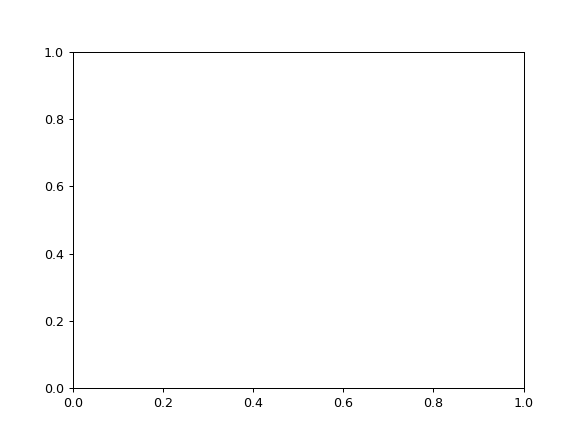

episode rewards: [58.0, 51.0, 68.0, 51.0, 58.0, 74.0, 59.0, 57.0, 59.0, 59.0, 55.0, 74.0, 48.0, 50.0, 58.0, 52.0, 60.0, 33.0, 58.0, 65.0, 48.0, 37.0, 61.0, 75.0, 57.0, 59.0, 57.0, 55.0, 39.0, 57.0, 54.0, 56.0, 66.0, 55.0, 64.0, 58.0, 50.0, 67.0, 63.0, 52.0, 59.0, 54.0, 58.0, 60.0, 43.0, 56.0, 54.0, 51.0, 50.0, 32.0] (mean = 55.88)


2021-08-25 21:36:28,598	INFO services.py:1272 -- View the Ray dashboard at http://127.0.0.1:8265
2021-08-25 21:36:32,447	WARNING util.py:53 -- Install gputil for GPU system monitoring.
2021-08-25 21:36:35,174	WARNING util.py:53 -- Install gputil for GPU system monitoring.


<IPython.core.display.Javascript object>


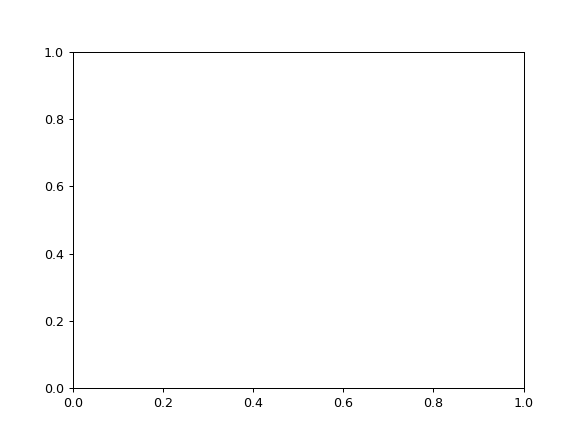

episode rewards: [56.0, 54.0, 56.0, 32.0, 48.0, 40.0, 34.0, 37.0, 27.0, 41.0, 31.0, 39.0, 42.0, 19.0, 32.0, 42.0, 34.0, 42.0, 43.0, 20.0, 36.0, 25.0, 23.0, 47.0, 44.0, 48.0, 54.0, 25.0, 18.0, 30.0, 41.0, 49.0, 52.0, 52.0, 40.0, 42.0, 32.0, 60.0, 29.0, 17.0, 25.0, 37.0, 35.0, 41.0, 19.0, 8.0, 48.0, 40.0, 42.0, 51.0] (mean = 37.58)


2021-08-25 21:36:52,610	INFO services.py:1272 -- View the Ray dashboard at http://127.0.0.1:8265
2021-08-25 21:36:57,070	WARNING util.py:53 -- Install gputil for GPU system monitoring.
2021-08-25 21:37:00,468	WARNING util.py:53 -- Install gputil for GPU system monitoring.


<IPython.core.display.Javascript object>


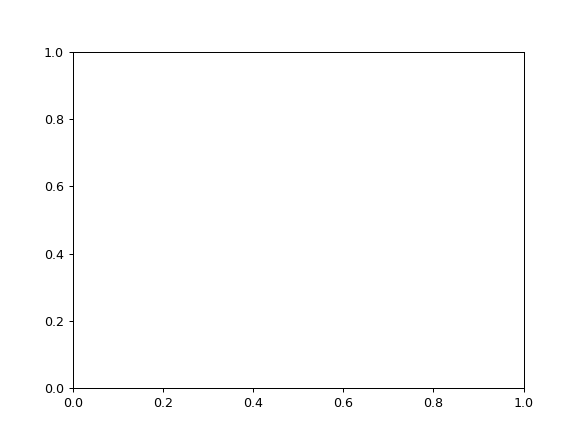

episode rewards: [67.0, 59.0, 44.0, 62.0, 70.0, 72.0, 74.0, 62.0, 74.0, 67.0, 62.0, 66.0, 62.0, 46.0, 69.0, 60.0, 62.0, 71.0, 64.0, 61.0, 70.0, 61.0, 59.0, 68.0, 57.0, 60.0, 66.0, 74.0, 63.0, 64.0, 63.0, 69.0, 56.0, 70.0, 65.0, 67.0, 71.0, 51.0, 60.0, 74.0, 61.0, 69.0, 44.0, 65.0, 63.0, 54.0, 56.0, 63.0, 63.0, 64.0] (mean = 63.28)


2021-08-25 21:37:18,045	INFO services.py:1272 -- View the Ray dashboard at http://127.0.0.1:8265
2021-08-25 21:37:21,970	WARNING util.py:53 -- Install gputil for GPU system monitoring.
2021-08-25 21:37:24,711	WARNING util.py:53 -- Install gputil for GPU system monitoring.


<IPython.core.display.Javascript object>


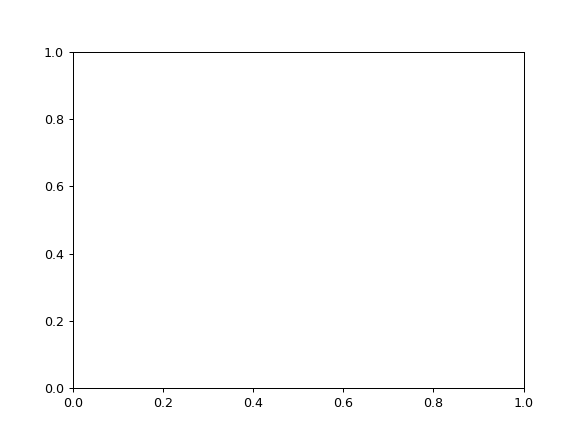

episode rewards: [41.0, 56.0, 63.0, 60.0, 65.0, 56.0, 57.0, 67.0, 71.0, 63.0, 53.0, 57.0, 62.0, 65.0, 51.0, 66.0, 50.0, 49.0, 55.0, 24.0, 57.0, 59.0, 65.0, 55.0, 47.0, 52.0, 75.0, 63.0, 56.0, 50.0, 55.0, 59.0, 45.0, 50.0, 63.0, 53.0, 46.0, 62.0, 55.0, 62.0, 53.0, 46.0, 59.0, 59.0, 64.0, 52.0, 69.0, 56.0, 60.0, 53.0] (mean = 56.62)


2021-08-25 21:37:42,486	INFO services.py:1272 -- View the Ray dashboard at http://127.0.0.1:8265
2021-08-25 21:37:46,339	WARNING util.py:53 -- Install gputil for GPU system monitoring.
2021-08-25 21:37:49,088	WARNING util.py:53 -- Install gputil for GPU system monitoring.


<IPython.core.display.Javascript object>


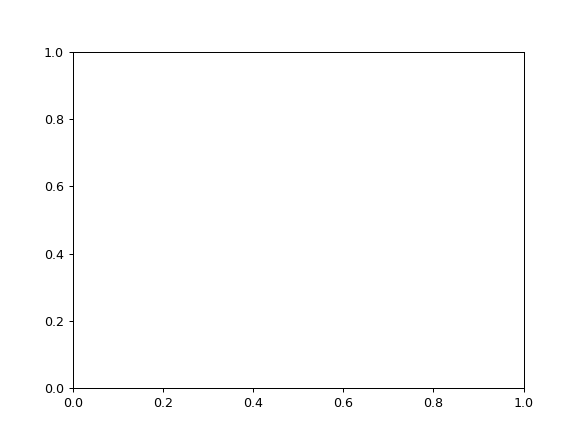

episode rewards: [43.0, 20.0, 59.0, 37.0, 36.0, 46.0, 44.0, 29.0, 35.0, 43.0, 47.0, 42.0, 20.0, 29.0, 9.0, 53.0, 31.0, 33.0, 28.0, 36.0, 40.0, 27.0, 40.0, 44.0, 57.0, 17.0, 41.0, 46.0, 47.0, 66.0, 51.0, 33.0, 61.0, 32.0, 44.0, 42.0, 38.0, 38.0, 34.0, 31.0, 19.0, 38.0, 19.0, 30.0, 32.0, 41.0, 38.0, 53.0, 57.0, 51.0] (mean = 38.54)


2021-08-25 21:38:07,547	INFO services.py:1272 -- View the Ray dashboard at http://127.0.0.1:8265
2021-08-25 21:38:11,324	WARNING util.py:53 -- Install gputil for GPU system monitoring.
2021-08-25 21:38:14,142	WARNING util.py:53 -- Install gputil for GPU system monitoring.


<IPython.core.display.Javascript object>


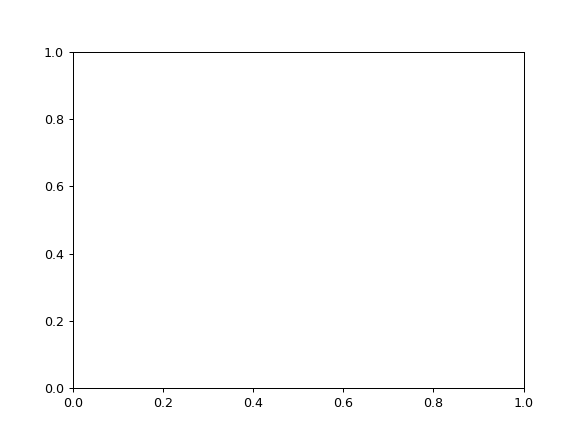

episode rewards: [67.0, 67.0, 79.0, 61.0, 53.0, 59.0, 66.0, 75.0, 62.0, 79.0, 49.0, 71.0, 55.0, 67.0, 72.0, 71.0, 69.0, 66.0, 75.0, 73.0, 68.0, 67.0, 61.0, 60.0, 67.0, 72.0, 65.0, 69.0, 55.0, 63.0, 72.0, 58.0, 58.0, 68.0, 74.0, 40.0, 62.0, 81.0, 74.0, 64.0, 69.0, 67.0, 67.0, 65.0, 73.0, 69.0, 65.0, 72.0, 62.0, 75.0] (mean = 66.36)


2021-08-25 21:38:31,763	INFO services.py:1272 -- View the Ray dashboard at http://127.0.0.1:8265
2021-08-25 21:38:35,478	WARNING util.py:53 -- Install gputil for GPU system monitoring.
2021-08-25 21:38:38,175	WARNING util.py:53 -- Install gputil for GPU system monitoring.


<IPython.core.display.Javascript object>


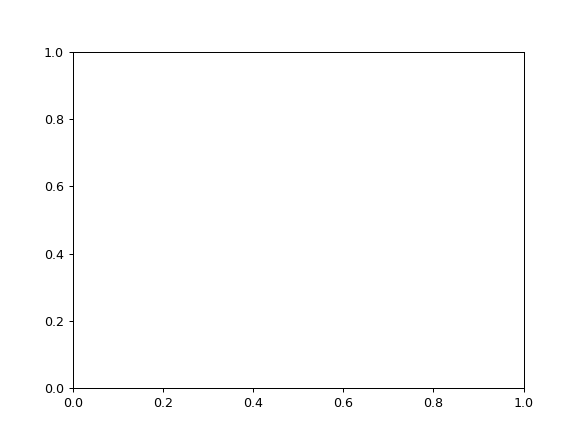

episode rewards: [77.0, 60.0, 58.0, 72.0, 59.0, 73.0, 50.0, 65.0, 70.0, 54.0, 57.0, 68.0, 60.0, 57.0, 72.0, 71.0, 74.0, 66.0, 53.0, 57.0, 79.0, 60.0, 57.0, 64.0, 66.0, 65.0, 68.0, 71.0, 44.0, 63.0, 42.0, 69.0, 59.0, 61.0, 66.0, 69.0, 71.0, 73.0, 72.0, 67.0, 58.0, 67.0, 49.0, 62.0, 53.0, 54.0, 70.0, 47.0, 47.0, 51.0] (mean = 62.34)


2021-08-25 21:38:55,600	INFO services.py:1272 -- View the Ray dashboard at http://127.0.0.1:8265
2021-08-25 21:38:59,297	WARNING util.py:53 -- Install gputil for GPU system monitoring.
2021-08-25 21:39:02,006	WARNING util.py:53 -- Install gputil for GPU system monitoring.


<IPython.core.display.Javascript object>


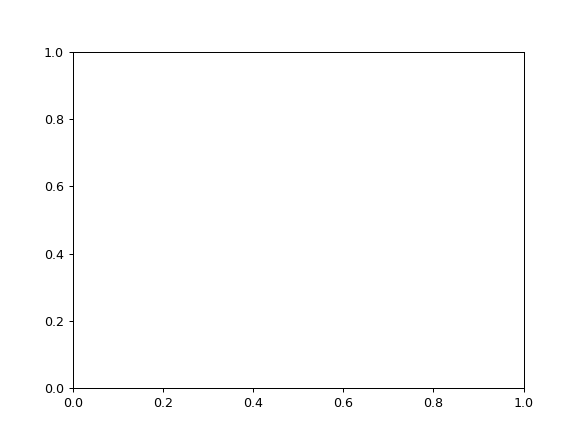

episode rewards: [37.0, 24.0, 55.0, 36.0, 51.0, 45.0, 52.0, 47.0, 35.0, 28.0, 36.0, 50.0, 36.0, 37.0, 17.0, 40.0, 41.0, 33.0, 29.0, 43.0, 44.0, 42.0, 43.0, 50.0, 37.0, 40.0, 39.0, 36.0, 17.0, 39.0, 48.0, 62.0, 37.0, 18.0, 50.0, 55.0, 26.0, 31.0, 54.0, 42.0, 49.0, 30.0, 47.0, 53.0, 65.0, 49.0, 45.0, 46.0, 47.0, 26.0] (mean = 40.78)


2021-08-25 21:39:20,582	INFO services.py:1272 -- View the Ray dashboard at http://127.0.0.1:8265
2021-08-25 21:39:24,304	WARNING util.py:53 -- Install gputil for GPU system monitoring.
2021-08-25 21:39:27,009	WARNING util.py:53 -- Install gputil for GPU system monitoring.


<IPython.core.display.Javascript object>


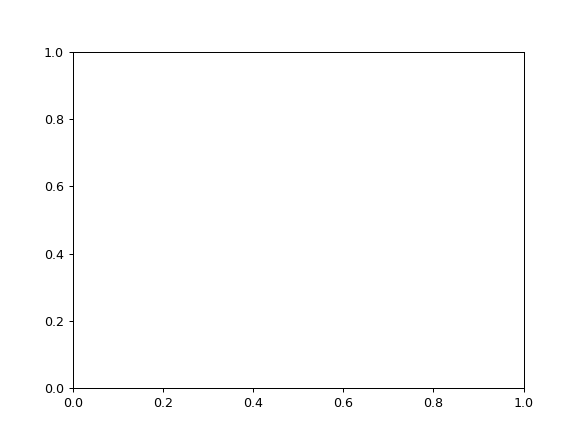

episode rewards: [69.0, 76.0, 70.0, 70.0, 76.0, 72.0, 68.0, 71.0, 52.0, 76.0, 62.0, 73.0, 61.0, 63.0, 56.0, 69.0, 61.0, 70.0, 73.0, 70.0, 76.0, 72.0, 77.0, 70.0, 77.0, 60.0, 48.0, 69.0, 69.0, 79.0, 70.0, 79.0, 75.0, 56.0, 66.0, 73.0, 77.0, 71.0, 70.0, 78.0, 58.0, 68.0, 75.0, 79.0, 46.0, 57.0, 70.0, 69.0, 68.0, 56.0] (mean = 68.32)


2021-08-25 21:39:44,889	INFO services.py:1272 -- View the Ray dashboard at http://127.0.0.1:8265
2021-08-25 21:39:48,680	WARNING util.py:53 -- Install gputil for GPU system monitoring.
2021-08-25 21:39:51,301	WARNING util.py:53 -- Install gputil for GPU system monitoring.


<IPython.core.display.Javascript object>


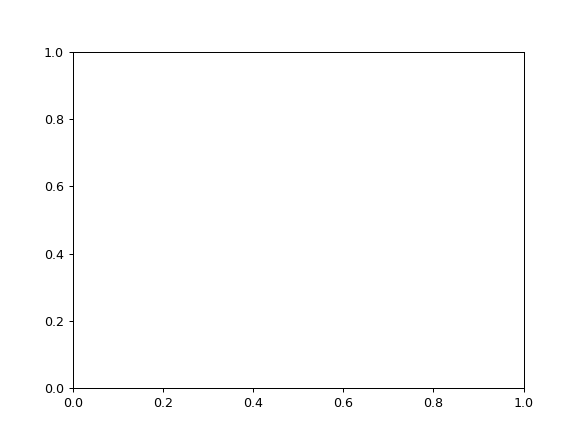

episode rewards: [69.0, 67.0, 67.0, 59.0, 56.0, 55.0, 64.0, 62.0, 71.0, 57.0, 73.0, 70.0, 63.0, 58.0, 65.0, 67.0, 73.0, 45.0, 68.0, 64.0, 72.0, 64.0, 67.0, 66.0, 65.0, 67.0, 60.0, 59.0, 59.0, 60.0, 71.0, 68.0, 71.0, 66.0, 67.0, 65.0, 70.0, 38.0, 49.0, 70.0, 70.0, 54.0, 68.0, 55.0, 66.0, 58.0, 66.0, 74.0, 76.0, 59.0] (mean = 63.86)


2021-08-25 21:40:08,667	INFO services.py:1272 -- View the Ray dashboard at http://127.0.0.1:8265
2021-08-25 21:40:12,689	WARNING util.py:53 -- Install gputil for GPU system monitoring.
2021-08-25 21:40:16,451	WARNING util.py:53 -- Install gputil for GPU system monitoring.


<IPython.core.display.Javascript object>


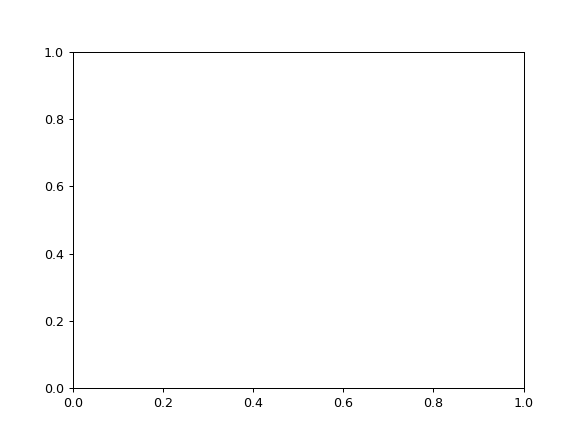

episode rewards: [40.0, 46.0, 15.0, 16.0, 50.0, 65.0, 54.0, 62.0, 46.0, 56.0, 46.0, 51.0, 56.0, 36.0, 22.0, 32.0, 25.0, 47.0, 20.0, 54.0, 61.0, 46.0, 13.0, 41.0, 23.0, 27.0, 31.0, 27.0, 44.0, 56.0, 30.0, 36.0, 33.0, 20.0, 52.0, 54.0, 45.0, 36.0, 21.0, 33.0, 20.0, 22.0, 61.0, 34.0, 39.0, 52.0, 42.0, 36.0, 55.0, 30.0] (mean = 39.18)


2021-08-25 21:40:34,302	INFO services.py:1272 -- View the Ray dashboard at http://127.0.0.1:8265
2021-08-25 21:40:38,056	WARNING util.py:53 -- Install gputil for GPU system monitoring.
2021-08-25 21:40:40,778	WARNING util.py:53 -- Install gputil for GPU system monitoring.


<IPython.core.display.Javascript object>


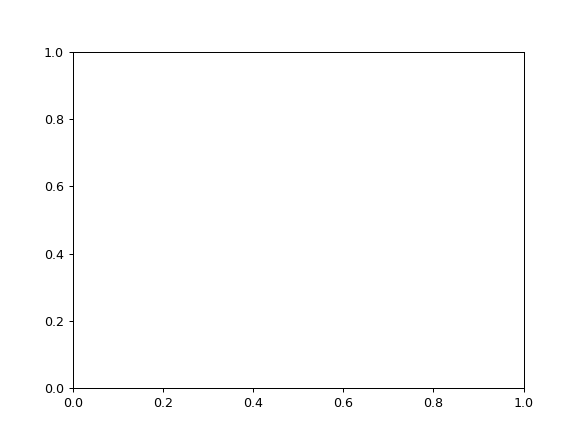

episode rewards: [78.0, 78.0, 81.0, 76.0, 73.0, 71.0, 75.0, 73.0, 80.0, 69.0, 75.0, 72.0, 71.0, 65.0, 75.0, 76.0, 58.0, 41.0, 73.0, 62.0, 79.0, 70.0, 76.0, 68.0, 76.0, 76.0, 75.0, 62.0, 78.0, 79.0, 84.0, 72.0, 76.0, 68.0, 74.0, 77.0, 72.0, 75.0, 75.0, 69.0, 76.0, 72.0, 64.0, 69.0, 83.0, 75.0, 74.0, 73.0, 67.0, 70.0] (mean = 72.52)


2021-08-25 21:40:59,000	INFO services.py:1272 -- View the Ray dashboard at http://127.0.0.1:8265
2021-08-25 21:41:02,813	WARNING util.py:53 -- Install gputil for GPU system monitoring.
2021-08-25 21:41:05,584	WARNING util.py:53 -- Install gputil for GPU system monitoring.


<IPython.core.display.Javascript object>


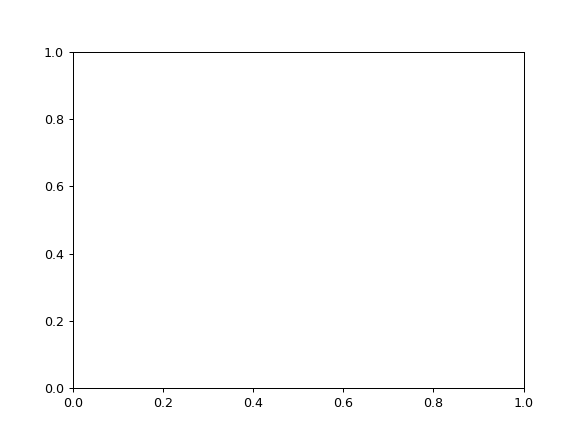

episode rewards: [67.0, 70.0, 72.0, 69.0, 66.0, 61.0, 70.0, 66.0, 59.0, 75.0, 67.0, 71.0, 70.0, 69.0, 66.0, 71.0, 72.0, 69.0, 59.0, 62.0, 68.0, 72.0, 73.0, 69.0, 72.0, 65.0, 60.0, 75.0, 63.0, 61.0, 61.0, 64.0, 60.0, 59.0, 65.0, 70.0, 66.0, 77.0, 65.0, 71.0, 69.0, 69.0, 73.0, 52.0, 72.0, 68.0, 75.0, 58.0, 79.0, 78.0] (mean = 67.6)


2021-08-25 21:41:26,281	INFO services.py:1272 -- View the Ray dashboard at http://127.0.0.1:8265
2021-08-25 21:41:30,024	WARNING util.py:53 -- Install gputil for GPU system monitoring.
2021-08-25 21:41:32,699	WARNING util.py:53 -- Install gputil for GPU system monitoring.


<IPython.core.display.Javascript object>


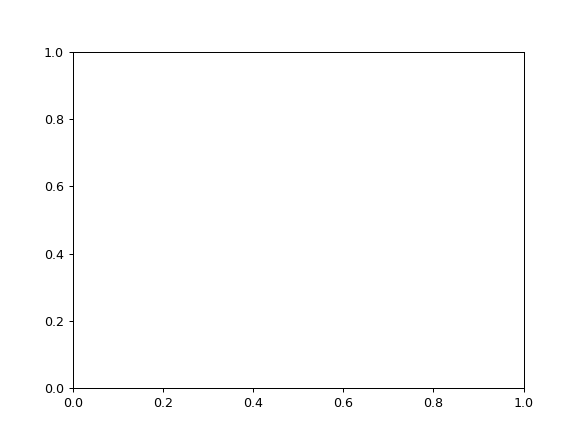

episode rewards: [16.0, 20.0, 25.0, 36.0, 57.0, 34.0, 52.0, 30.0, 37.0, 54.0, 21.0, 55.0, 13.0, 31.0, 72.0, 15.0, 24.0, 37.0, 40.0, 44.0, 39.0, 35.0, 23.0, 56.0, 51.0, 24.0, 39.0, 22.0, 56.0, 27.0, 14.0, 21.0, 53.0, 50.0, 26.0, 55.0, 49.0, 58.0, 36.0, 19.0, 41.0, 22.0, 22.0, 51.0, 35.0, 36.0, 46.0, 44.0, 53.0, 48.0] (mean = 37.28)


2021-08-25 21:41:50,049	INFO services.py:1272 -- View the Ray dashboard at http://127.0.0.1:8265
2021-08-25 21:41:53,774	WARNING util.py:53 -- Install gputil for GPU system monitoring.
2021-08-25 21:41:56,474	WARNING util.py:53 -- Install gputil for GPU system monitoring.


<IPython.core.display.Javascript object>


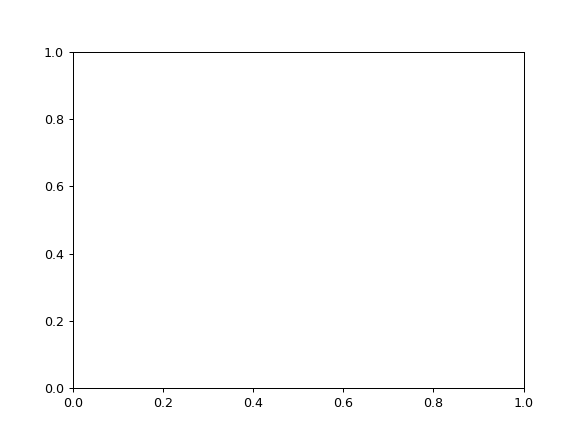

episode rewards: [76.0, 78.0, 85.0, 79.0, 80.0, 81.0, 80.0, 79.0, 69.0, 63.0, 81.0, 80.0, 77.0, 77.0, 77.0, 79.0, 80.0, 47.0, 82.0, 83.0, 80.0, 77.0, 77.0, 47.0, 77.0, 75.0, 69.0, 82.0, 82.0, 81.0, 80.0, 79.0, 82.0, 75.0, 80.0, 78.0, 82.0, 79.0, 82.0, 79.0, 79.0, 84.0, 77.0, 78.0, 83.0, 74.0, 79.0, 81.0, 70.0, 72.0] (mean = 77.06)


2021-08-25 21:42:13,482	INFO services.py:1272 -- View the Ray dashboard at http://127.0.0.1:8265
2021-08-25 21:42:17,124	WARNING util.py:53 -- Install gputil for GPU system monitoring.
2021-08-25 21:42:19,833	WARNING util.py:53 -- Install gputil for GPU system monitoring.


<IPython.core.display.Javascript object>


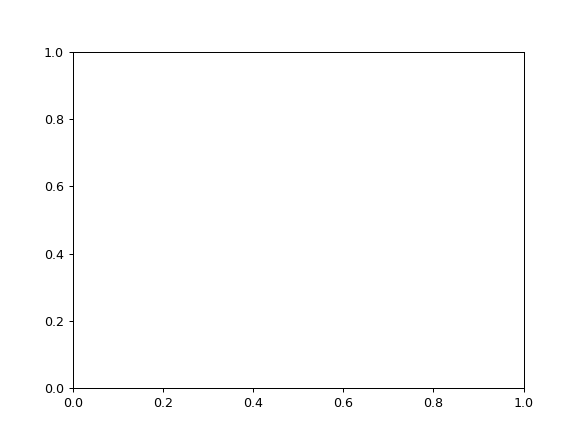

episode rewards: [75.0, 75.0, 50.0, 72.0, 53.0, 65.0, 56.0, 64.0, 69.0, 71.0, 73.0, 58.0, 65.0, 48.0, 72.0, 71.0, 53.0, 50.0, 73.0, 75.0, 63.0, 72.0, 69.0, 71.0, 54.0, 73.0, 72.0, 63.0, 70.0, 70.0, 71.0, 72.0, 75.0, 70.0, 59.0, 72.0, 76.0, 70.0, 68.0, 69.0, 76.0, 75.0, 72.0, 62.0, 57.0, 78.0, 72.0, 74.0, 65.0, 71.0] (mean = 67.38)


2021-08-25 21:42:39,130	INFO services.py:1272 -- View the Ray dashboard at http://127.0.0.1:8265
2021-08-25 21:42:42,995	WARNING util.py:53 -- Install gputil for GPU system monitoring.
2021-08-25 21:42:45,763	WARNING util.py:53 -- Install gputil for GPU system monitoring.


<IPython.core.display.Javascript object>


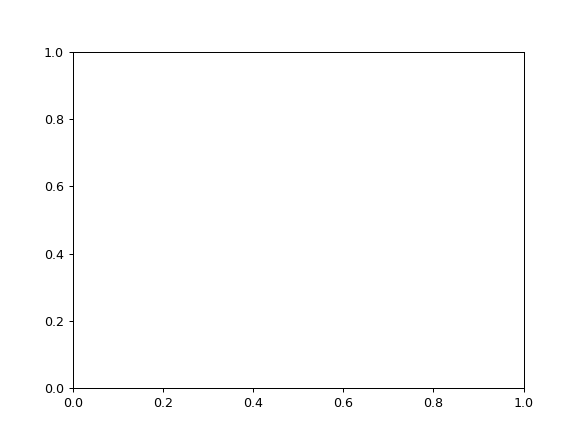

episode rewards: [36.0, 42.0, 20.0, 14.0, 45.0, 15.0, 45.0, 40.0, 55.0, 10.0, 44.0, 35.0, 50.0, 22.0, 39.0, 27.0, 24.0, 56.0, 25.0, 51.0, 58.0, 14.0, 15.0, 61.0, 46.0, 18.0, 26.0, 48.0, 46.0, 37.0, 16.0, 42.0, 10.0, 49.0, 42.0, 43.0, 47.0, 32.0, 61.0, 17.0, 14.0, 60.0, 19.0, 9.0, 40.0, 39.0, 24.0, 43.0, 38.0, 17.0] (mean = 34.52)


2021-08-25 21:43:03,970	INFO services.py:1272 -- View the Ray dashboard at http://127.0.0.1:8265
2021-08-25 21:43:07,833	WARNING util.py:53 -- Install gputil for GPU system monitoring.
2021-08-25 21:43:10,579	WARNING util.py:53 -- Install gputil for GPU system monitoring.


<IPython.core.display.Javascript object>


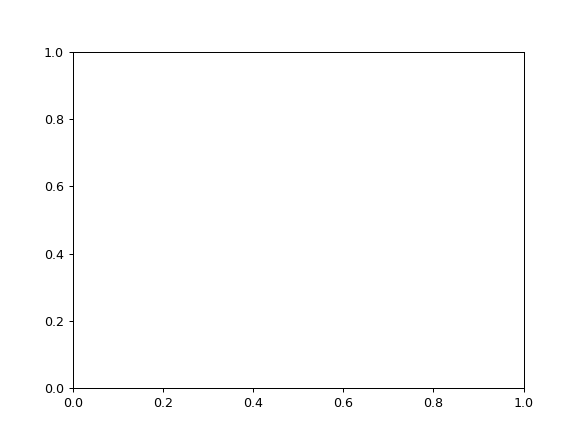

episode rewards: [83.0, 81.0, 71.0, 81.0, 82.0, 83.0, 81.0, 77.0, 82.0, 86.0, 78.0, 84.0, 74.0, 84.0, 81.0, 79.0, 81.0, 29.0, 82.0, 82.0, 80.0, 79.0, 86.0, 81.0, 79.0, 84.0, 79.0, 81.0, 66.0, 84.0, 80.0, 70.0, 78.0, 83.0, 80.0, 82.0, 82.0, 51.0, 83.0, 84.0, 82.0, 79.0, 83.0, 86.0, 80.0, 82.0, 78.0, 83.0, 78.0, 85.0] (mean = 78.98)


2021-08-25 21:43:28,370	INFO services.py:1272 -- View the Ray dashboard at http://127.0.0.1:8265
2021-08-25 21:43:33,164	WARNING util.py:53 -- Install gputil for GPU system monitoring.
2021-08-25 21:43:36,317	WARNING util.py:53 -- Install gputil for GPU system monitoring.


<IPython.core.display.Javascript object>


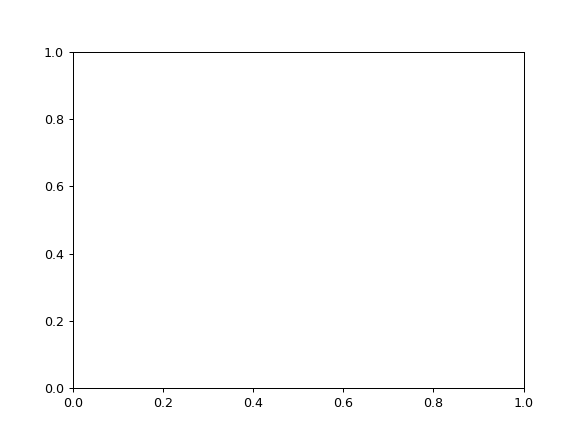

episode rewards: [73.0, 71.0, 77.0, 61.0, 52.0, 74.0, 69.0, 75.0, 75.0, 73.0, 79.0, 71.0, 76.0, 48.0, 79.0, 73.0, 80.0, 69.0, 64.0, 83.0, 72.0, 76.0, 78.0, 70.0, 58.0, 79.0, 74.0, 75.0, 64.0, 69.0, 72.0, 76.0, 59.0, 66.0, 81.0, 82.0, 68.0, 75.0, 64.0, 69.0, 80.0, 79.0, 78.0, 71.0, 76.0, 76.0, 70.0, 77.0, 80.0, 73.0] (mean = 72.18)


2021-08-25 21:43:53,514	INFO services.py:1272 -- View the Ray dashboard at http://127.0.0.1:8265
2021-08-25 21:43:57,300	WARNING util.py:53 -- Install gputil for GPU system monitoring.
2021-08-25 21:44:00,024	WARNING util.py:53 -- Install gputil for GPU system monitoring.


<IPython.core.display.Javascript object>


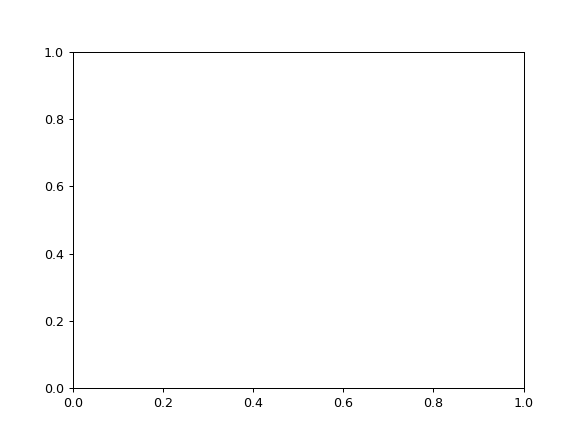

episode rewards: [45.0, 24.0, 15.0, 19.0, 41.0, 45.0, 27.0, 27.0, 15.0, 23.0, 48.0, 48.0, 19.0, 31.0, 40.0, 14.0, 61.0, 50.0, 37.0, 37.0, 18.0, 56.0, 49.0, 21.0, 19.0, 29.0, 15.0, 36.0, 17.0, 48.0, 50.0, 15.0, 29.0, 28.0, 50.0, 36.0, 21.0, 17.0, 38.0, 35.0, 42.0, 48.0, 46.0, 27.0, 14.0, 34.0, 56.0, 28.0, 53.0, 16.0] (mean = 33.14)


2021-08-25 21:44:17,430	INFO services.py:1272 -- View the Ray dashboard at http://127.0.0.1:8265
2021-08-25 21:44:21,354	WARNING util.py:53 -- Install gputil for GPU system monitoring.
2021-08-25 21:44:24,230	WARNING util.py:53 -- Install gputil for GPU system monitoring.


<IPython.core.display.Javascript object>


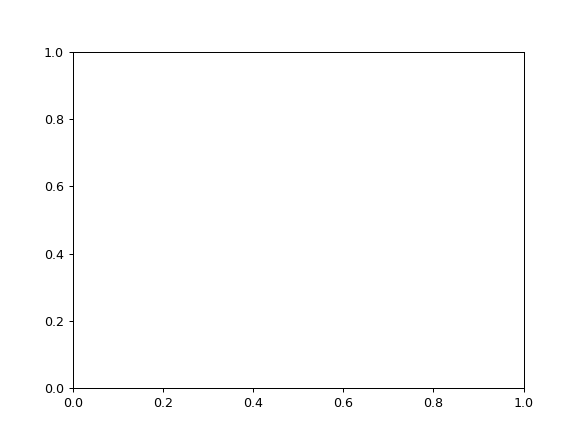

episode rewards: [85.0, 75.0, 78.0, 85.0, 76.0, 82.0, 88.0, 61.0, 87.0, 87.0, 86.0, 86.0, 68.0, 75.0, 64.0, 82.0, 88.0, 66.0, 84.0, 65.0, 86.0, 84.0, 87.0, 78.0, 81.0, 84.0, 82.0, 85.0, 84.0, 79.0, 87.0, 76.0, 83.0, 85.0, 82.0, 89.0, 84.0, 84.0, 86.0, 72.0, 85.0, 72.0, 87.0, 81.0, 84.0, 66.0, 85.0, 85.0, 85.0, 81.0] (mean = 80.74)


2021-08-25 21:44:43,212	INFO services.py:1272 -- View the Ray dashboard at http://127.0.0.1:8265
2021-08-25 21:44:46,973	WARNING util.py:53 -- Install gputil for GPU system monitoring.
2021-08-25 21:44:49,696	WARNING util.py:53 -- Install gputil for GPU system monitoring.


<IPython.core.display.Javascript object>


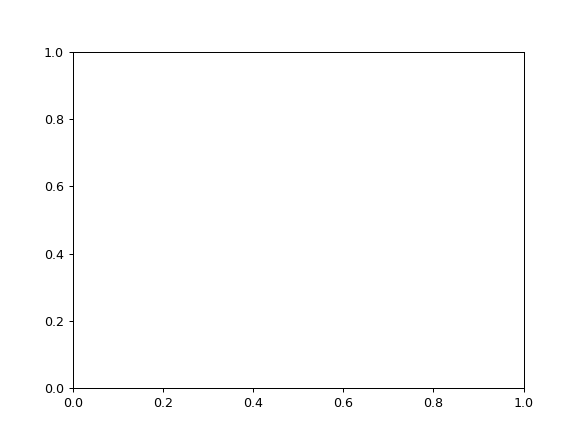

episode rewards: [80.0, 78.0, 79.0, 85.0, 75.0, 75.0, 87.0, 84.0, 65.0, 81.0, 82.0, 88.0, 76.0, 78.0, 83.0, 82.0, 81.0, 78.0, 74.0, 70.0, 57.0, 74.0, 70.0, 82.0, 75.0, 77.0, 83.0, 80.0, 64.0, 57.0, 73.0, 79.0, 66.0, 76.0, 78.0, 86.0, 80.0, 74.0, 63.0, 82.0, 75.0, 74.0, 71.0, 63.0, 80.0, 77.0, 68.0, 72.0, 79.0, 41.0] (mean = 75.14)


2021-08-25 21:45:07,565	INFO services.py:1272 -- View the Ray dashboard at http://127.0.0.1:8265
2021-08-25 21:45:11,316	WARNING util.py:53 -- Install gputil for GPU system monitoring.
2021-08-25 21:45:13,987	WARNING util.py:53 -- Install gputil for GPU system monitoring.


<IPython.core.display.Javascript object>


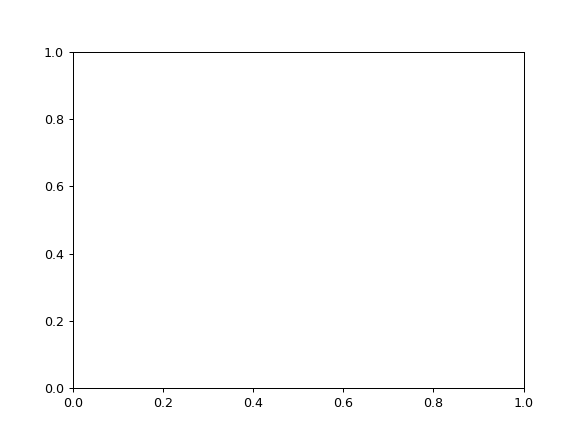

episode rewards: [30.0, 21.0, 15.0, 31.0, 17.0, 32.0, 47.0, 26.0, 53.0, 7.0, 24.0, 50.0, 59.0, 22.0, 22.0, 38.0, 34.0, 15.0, 40.0, 49.0, 36.0, 18.0, 23.0, 16.0, 16.0, 40.0, 23.0, 29.0, 33.0, 27.0, 17.0, 22.0, 19.0, 31.0, 38.0, 42.0, 57.0, 34.0, 23.0, 23.0, 17.0, 14.0, 9.0, 16.0, 36.0, 28.0, 39.0, 26.0, 22.0, 38.0] (mean = 28.88)


2021-08-25 21:45:31,350	INFO services.py:1272 -- View the Ray dashboard at http://127.0.0.1:8265
2021-08-25 21:45:35,077	WARNING util.py:53 -- Install gputil for GPU system monitoring.
2021-08-25 21:45:37,776	WARNING util.py:53 -- Install gputil for GPU system monitoring.


<IPython.core.display.Javascript object>


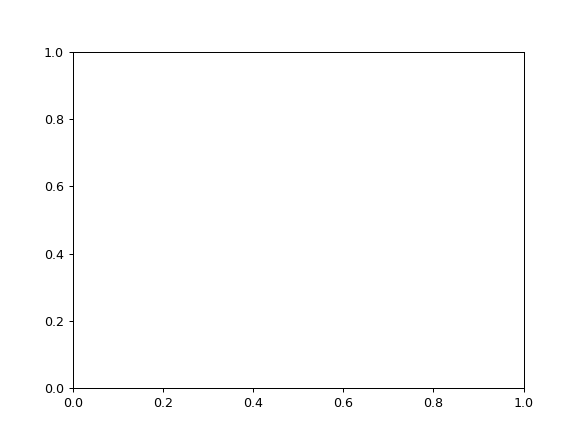

episode rewards: [78.0, 74.0, 83.0, 69.0, 87.0, 84.0, 83.0, 75.0, 88.0, 86.0, 88.0, 85.0, 71.0, 71.0, 62.0, 88.0, 83.0, 86.0, 86.0, 86.0, 86.0, 78.0, 86.0, 44.0, 82.0, 87.0, 84.0, 84.0, 84.0, 84.0, 81.0, 85.0, 85.0, 89.0, 83.0, 89.0, 87.0, 86.0, 86.0, 89.0, 88.0, 84.0, 83.0, 65.0, 87.0, 78.0, 84.0, 88.0, 78.0, 87.0] (mean = 81.88)


2021-08-25 21:45:56,512	INFO services.py:1272 -- View the Ray dashboard at http://127.0.0.1:8265
2021-08-25 21:46:00,302	WARNING util.py:53 -- Install gputil for GPU system monitoring.
2021-08-25 21:46:02,987	WARNING util.py:53 -- Install gputil for GPU system monitoring.


<IPython.core.display.Javascript object>


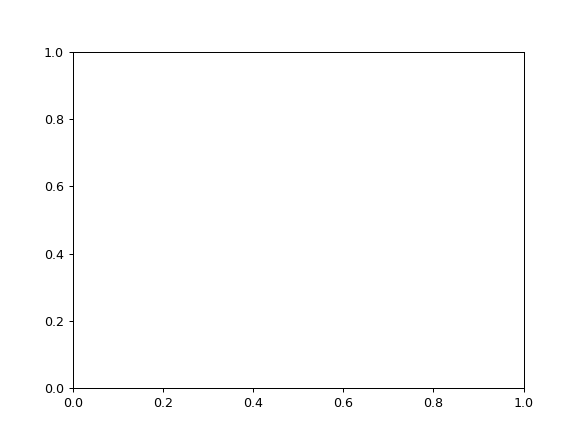

episode rewards: [85.0, 86.0, 84.0, 88.0, 86.0, 81.0, 81.0, 82.0, 77.0, 67.0, 79.0, 89.0, 70.0, 83.0, 82.0, 77.0, 80.0, 78.0, 81.0, 88.0, 86.0, 88.0, 86.0, 79.0, 84.0, 81.0, 73.0, 79.0, 83.0, 68.0, 89.0, 89.0, 77.0, 83.0, 87.0, 85.0, 80.0, 90.0, 86.0, 91.0, 76.0, 87.0, 85.0, 46.0, 79.0, 79.0, 67.0, 72.0, 77.0, 41.0] (mean = 79.94)


2021-08-25 21:46:21,168	INFO services.py:1272 -- View the Ray dashboard at http://127.0.0.1:8265
2021-08-25 21:46:24,940	WARNING util.py:53 -- Install gputil for GPU system monitoring.
2021-08-25 21:46:27,698	WARNING util.py:53 -- Install gputil for GPU system monitoring.


<IPython.core.display.Javascript object>


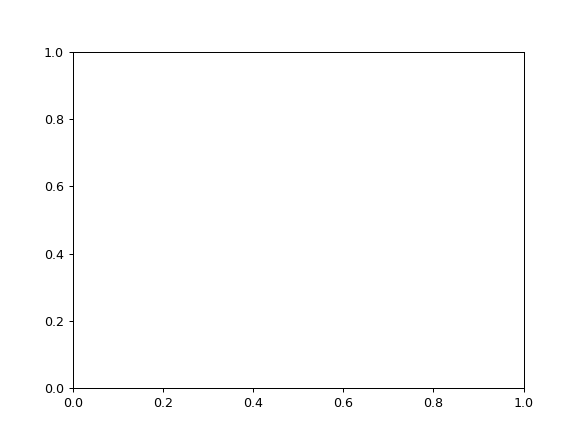

episode rewards: [30.0, 38.0, 18.0, 33.0, 19.0, 42.0, 30.0, 9.0, 37.0, 31.0, -11.0, 16.0, 41.0, 18.0, 17.0, 30.0, 27.0, 12.0, 18.0, -11.0, 6.0, 16.0, 17.0, 10.0, 17.0, 17.0, 22.0, 33.0, 6.0, 2.0, 1.0, 15.0, 19.0, 27.0, 32.0, 11.0, 17.0, 29.0, 17.0, 23.0, 7.0, -11.0, 32.0, 15.0, 44.0, 14.0, 6.0, 15.0, 42.0, 1.0] (mean = 18.92)


2021-08-25 21:46:45,517	INFO services.py:1272 -- View the Ray dashboard at http://127.0.0.1:8265
2021-08-25 21:46:50,258	WARNING util.py:53 -- Install gputil for GPU system monitoring.
2021-08-25 21:46:53,001	WARNING util.py:53 -- Install gputil for GPU system monitoring.


<IPython.core.display.Javascript object>


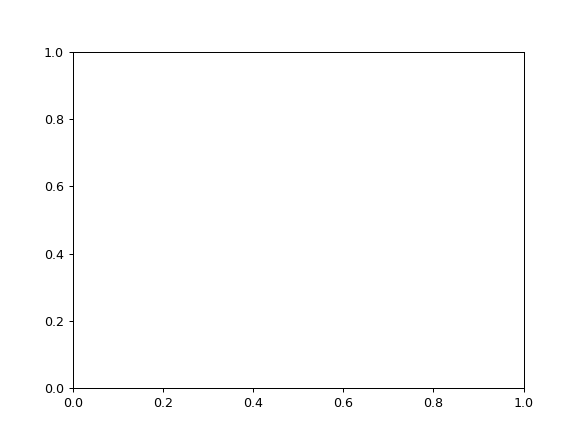

episode rewards: [88.0, 86.0, 83.0, 84.0, 60.0, 69.0, 84.0, 70.0, 55.0, 34.0, 88.0, 59.0, 48.0, 87.0, 88.0, 87.0, 83.0, 54.0, 84.0, 61.0, 88.0, 86.0, 88.0, 56.0, 87.0, 87.0, 88.0, 89.0, 13.0, 79.0, 88.0, 89.0, 89.0, 86.0, 60.0, 87.0, 83.0, 86.0, 79.0, 85.0, 64.0, 84.0, 87.0, 85.0, 83.0, 72.0, 89.0, 85.0, 84.0, 60.0] (mean = 76.76)


2021-08-25 21:47:10,801	INFO services.py:1272 -- View the Ray dashboard at http://127.0.0.1:8265
2021-08-25 21:47:14,683	WARNING util.py:53 -- Install gputil for GPU system monitoring.
2021-08-25 21:47:17,480	WARNING util.py:53 -- Install gputil for GPU system monitoring.


<IPython.core.display.Javascript object>


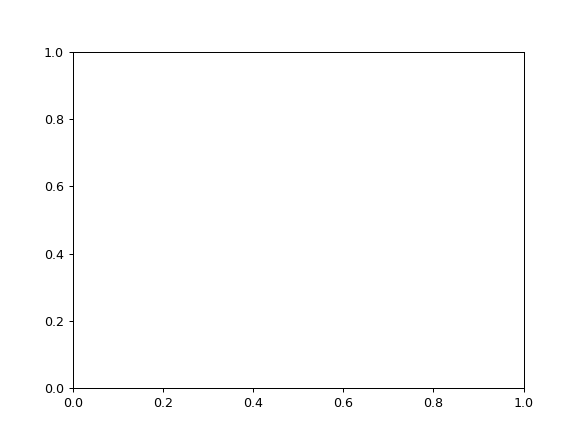

episode rewards: [49.0, 89.0, 79.0, 87.0, 77.0, 88.0, 85.0, 89.0, 70.0, 88.0, 89.0, 91.0, 81.0, 88.0, 89.0, 92.0, 89.0, 91.0, 88.0, 89.0, 68.0, 92.0, 89.0, 86.0, 69.0, 82.0, 73.0, 89.0, 87.0, 87.0, 89.0, 87.0, 81.0, 84.0, 87.0, 88.0, 84.0, 89.0, 77.0, 90.0, 89.0, 80.0, 88.0, 89.0, 89.0, 89.0, 65.0, 87.0, 88.0, 88.0] (mean = 84.36)


2021-08-25 21:47:35,019	INFO services.py:1272 -- View the Ray dashboard at http://127.0.0.1:8265
2021-08-25 21:47:38,748	WARNING util.py:53 -- Install gputil for GPU system monitoring.
2021-08-25 21:47:41,491	WARNING util.py:53 -- Install gputil for GPU system monitoring.


<IPython.core.display.Javascript object>


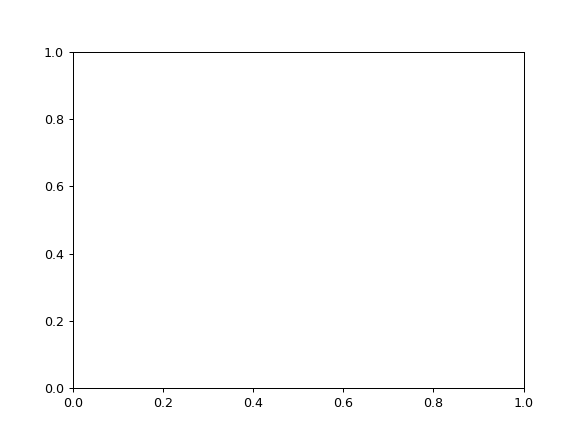

episode rewards: [52.0, 52.0, -11.0, 47.0, 8.0, 34.0, 27.0, 27.0, 32.0, 9.0, -6.0, -13.0, 27.0, 50.0, 50.0, 14.0, 64.0, 20.0, 31.0, 11.0, 30.0, 12.0, 17.0, 7.0, 21.0, 25.0, 19.0, 28.0, 50.0, 16.0, 18.0, 15.0, 12.0, 15.0, 29.0, 45.0, 43.0, 25.0, 12.0, 33.0, 16.0, 15.0, 30.0, 21.0, 36.0, 12.0, 12.0, 43.0, 46.0, 18.0] (mean = 24.92)


2021-08-25 21:48:02,767	INFO services.py:1272 -- View the Ray dashboard at http://127.0.0.1:8265
2021-08-25 21:48:06,591	WARNING util.py:53 -- Install gputil for GPU system monitoring.
2021-08-25 21:48:09,300	WARNING util.py:53 -- Install gputil for GPU system monitoring.


<IPython.core.display.Javascript object>


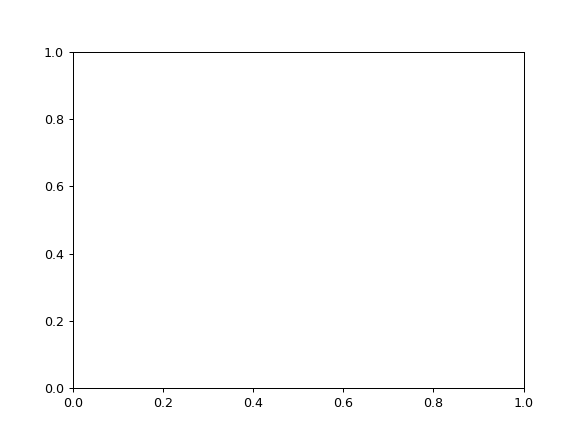

episode rewards: [89.0, 90.0, 89.0, 92.0, 75.0, 87.0, 89.0, 88.0, 65.0, 90.0, 88.0, 91.0, 62.0, 90.0, 61.0, 90.0, 87.0, 34.0, 90.0, 86.0, 47.0, 88.0, 88.0, 61.0, 91.0, 82.0, 90.0, 80.0, 63.0, 79.0, 88.0, 89.0, 87.0, 87.0, 85.0, 88.0, 90.0, 91.0, 90.0, 87.0, 91.0, 87.0, 89.0, 81.0, 87.0, 91.0, 82.0, 84.0, 88.0, 82.0] (mean = 82.92)


2021-08-25 21:48:26,532	INFO services.py:1272 -- View the Ray dashboard at http://127.0.0.1:8265
2021-08-25 21:48:30,364	WARNING util.py:53 -- Install gputil for GPU system monitoring.
2021-08-25 21:48:33,149	WARNING util.py:53 -- Install gputil for GPU system monitoring.


<IPython.core.display.Javascript object>


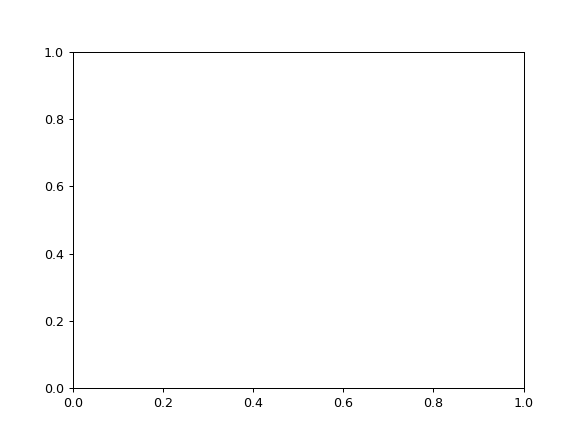

episode rewards: [67.0, 91.0, 86.0, 84.0, 85.0, 90.0, 91.0, 91.0, 79.0, 86.0, 89.0, 91.0, 60.0, 84.0, 91.0, 89.0, 91.0, 91.0, 86.0, 89.0, 81.0, 86.0, 91.0, 82.0, 79.0, 89.0, 79.0, 61.0, 90.0, 87.0, 91.0, 87.0, 84.0, 72.0, 83.0, 92.0, 81.0, 88.0, 57.0, 88.0, 90.0, 86.0, 91.0, 89.0, 83.0, 91.0, 75.0, 86.0, 89.0, 84.0] (mean = 84.46)


2021-08-25 21:48:50,430	INFO services.py:1272 -- View the Ray dashboard at http://127.0.0.1:8265
2021-08-25 21:48:54,271	WARNING util.py:53 -- Install gputil for GPU system monitoring.
2021-08-25 21:48:57,015	WARNING util.py:53 -- Install gputil for GPU system monitoring.


<IPython.core.display.Javascript object>


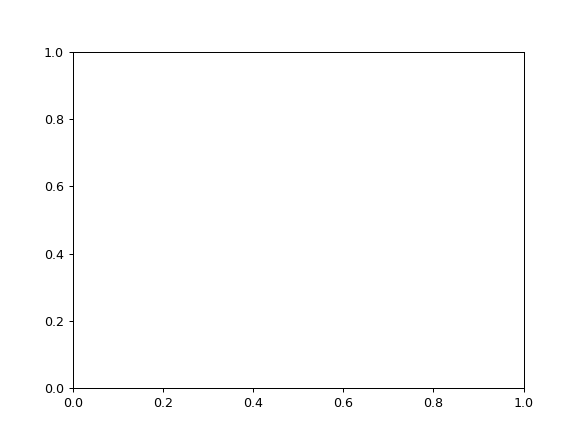

episode rewards: [50.0, 16.0, 26.0, 56.0, 46.0, 28.0, 29.0, 19.0, 31.0, 13.0, -2.0, 18.0, 25.0, 50.0, 27.0, 15.0, 20.0, 17.0, 40.0, 37.0, 10.0, 22.0, 27.0, 31.0, 17.0, 13.0, 25.0, 20.0, 42.0, 36.0, 19.0, 16.0, 18.0, 20.0, 31.0, 27.0, 17.0, 25.0, 19.0, 15.0, 16.0, 37.0, 20.0, 16.0, 16.0, 26.0, 34.0, 31.0, 32.0, 48.0] (mean = 25.74)


2021-08-25 21:49:16,300	INFO services.py:1272 -- View the Ray dashboard at http://127.0.0.1:8265
2021-08-25 21:49:20,068	WARNING util.py:53 -- Install gputil for GPU system monitoring.
2021-08-25 21:49:22,753	WARNING util.py:53 -- Install gputil for GPU system monitoring.


<IPython.core.display.Javascript object>


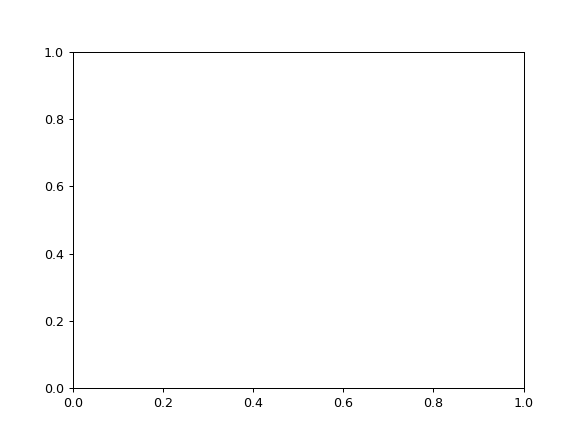

episode rewards: [90.0, 91.0, 53.0, 90.0, 89.0, 77.0, 88.0, 84.0, 70.0, 90.0, 91.0, 89.0, 71.0, 91.0, 65.0, 91.0, 74.0, 73.0, 89.0, 90.0, 48.0, 86.0, 90.0, 91.0, 89.0, 72.0, 87.0, 90.0, 76.0, 89.0, 91.0, 76.0, 91.0, 88.0, 91.0, 89.0, 91.0, 89.0, 89.0, 91.0, 91.0, 84.0, 90.0, 90.0, 89.0, 89.0, 90.0, 90.0, 90.0, 67.0] (mean = 84.4)


2021-08-25 21:49:39,632	INFO services.py:1272 -- View the Ray dashboard at http://127.0.0.1:8265
2021-08-25 21:49:43,362	WARNING util.py:53 -- Install gputil for GPU system monitoring.
2021-08-25 21:49:46,059	WARNING util.py:53 -- Install gputil for GPU system monitoring.


<IPython.core.display.Javascript object>


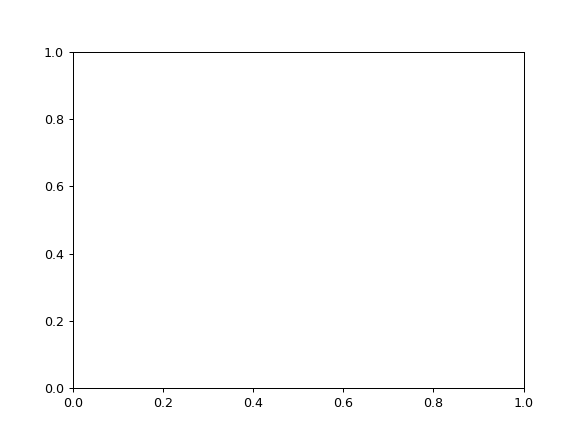

episode rewards: [88.0, 89.0, 86.0, 78.0, 77.0, 87.0, 85.0, 91.0, 61.0, 88.0, 77.0, 90.0, 87.0, 85.0, 92.0, 89.0, 91.0, 87.0, 91.0, 91.0, 80.0, 66.0, 87.0, 90.0, 74.0, 87.0, 87.0, 91.0, 90.0, 74.0, 91.0, 80.0, 77.0, 88.0, 83.0, 87.0, 78.0, 87.0, 72.0, 87.0, 91.0, 92.0, 89.0, 52.0, 82.0, 84.0, 50.0, 86.0, 78.0, 70.0] (mean = 82.8)


2021-08-25 21:50:03,627	INFO services.py:1272 -- View the Ray dashboard at http://127.0.0.1:8265
2021-08-25 21:50:08,578	WARNING util.py:53 -- Install gputil for GPU system monitoring.
2021-08-25 21:50:11,289	WARNING util.py:53 -- Install gputil for GPU system monitoring.


<IPython.core.display.Javascript object>


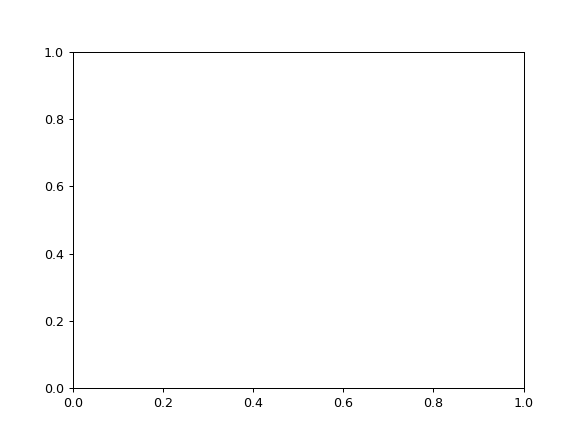

episode rewards: [13.0, 17.0, -14.0, 12.0, -14.0, 27.0, 13.0, 2.0, 15.0, -12.0, -14.0, -3.0, 21.0, 15.0, 12.0, 37.0, 26.0, 27.0, 36.0, 18.0, 24.0, -14.0, 27.0, 20.0, 14.0, 53.0, -12.0, -1.0, 21.0, 13.0, -12.0, 37.0, 10.0, 28.0, 32.0, 38.0, 1.0, 6.0, 43.0, 19.0, -12.0, 46.0, 20.0, -14.0, 35.0, 14.0, 39.0, 4.0, 46.0, -14.0] (mean = 14.9)


2021-08-25 21:50:28,739	INFO services.py:1272 -- View the Ray dashboard at http://127.0.0.1:8265
2021-08-25 21:50:32,538	WARNING util.py:53 -- Install gputil for GPU system monitoring.
2021-08-25 21:50:35,530	WARNING util.py:53 -- Install gputil for GPU system monitoring.


<IPython.core.display.Javascript object>


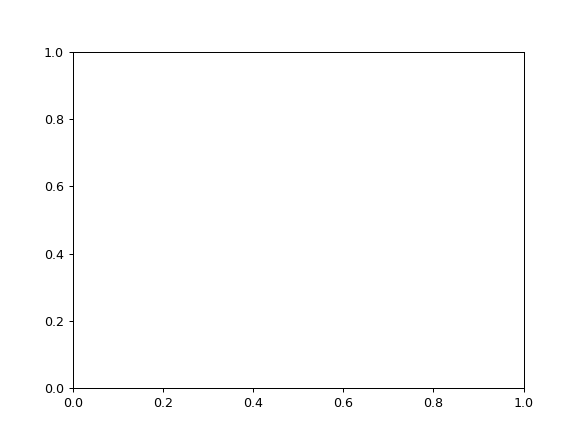

episode rewards: [89.0, 84.0, 76.0, 84.0, 83.0, 86.0, 90.0, 87.0, 74.0, 90.0, 89.0, 91.0, 75.0, 90.0, 92.0, 92.0, 87.0, 78.0, 89.0, 88.0, 91.0, 86.0, 90.0, 76.0, 82.0, 84.0, 90.0, 88.0, 79.0, 90.0, 92.0, 90.0, 88.0, 74.0, 90.0, 90.0, 90.0, 89.0, 92.0, 87.0, 90.0, 87.0, 91.0, 89.0, 88.0, 81.0, 89.0, 83.0, 84.0, 86.0] (mean = 86.4)


2021-08-25 21:50:53,926	INFO services.py:1272 -- View the Ray dashboard at http://127.0.0.1:8265
2021-08-25 21:50:55,136	WARNING worker.py:1123 -- The agent on node anvil failed with the following error:
Traceback (most recent call last):
  File "/home/anchorwatt/miniconda3/envs/zsc-cleaner/lib/python3.8/site-packages/ray/new_dashboard/agent.py", line 326, in <module>
    loop.run_until_complete(agent.run())
  File "/home/anchorwatt/miniconda3/envs/zsc-cleaner/lib/python3.8/asyncio/base_events.py", line 616, in run_until_complete
    return future.result()
  File "/home/anchorwatt/miniconda3/envs/zsc-cleaner/lib/python3.8/site-packages/ray/new_dashboard/agent.py", line 138, in run
    modules = self._load_modules()
  File "/home/anchorwatt/miniconda3/envs/zsc-cleaner/lib/python3.8/site-packages/ray/new_dashboard/agent.py", line 92, in _load_modules
    c = cls(self)
  File "/home/anchorwatt/miniconda3/envs/zsc-cleaner/lib/python3.8/site-packages/ray/new_dashboard/modules/reporter/repor

(raylet) Traceback (most recent call last):
(raylet)   File "/home/anchorwatt/miniconda3/envs/zsc-cleaner/lib/python3.8/site-packages/ray/new_dashboard/agent.py", line 338, in <module>
(raylet)     raise e
(raylet)   File "/home/anchorwatt/miniconda3/envs/zsc-cleaner/lib/python3.8/site-packages/ray/new_dashboard/agent.py", line 326, in <module>
(raylet)     loop.run_until_complete(agent.run())
(raylet)   File "/home/anchorwatt/miniconda3/envs/zsc-cleaner/lib/python3.8/asyncio/base_events.py", line 616, in run_until_complete
(raylet)     return future.result()
(raylet)   File "/home/anchorwatt/miniconda3/envs/zsc-cleaner/lib/python3.8/site-packages/ray/new_dashboard/agent.py", line 138, in run
(raylet)     modules = self._load_modules()
(raylet)   File "/home/anchorwatt/miniconda3/envs/zsc-cleaner/lib/python3.8/site-packages/ray/new_dashboard/agent.py", line 92, in _load_modules
(raylet)     c = cls(self)
(raylet)   File "/home/anchorwatt/miniconda3/envs/zsc-cleaner/lib/python3.8/site-p

2021-08-25 21:51:00,738	WARNING util.py:53 -- Install gputil for GPU system monitoring.


<IPython.core.display.Javascript object>


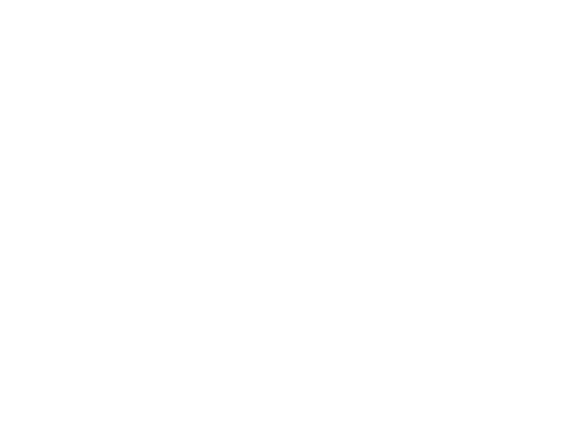

2021-08-25 21:51:00,816	WARNING worker.py:1123 -- The agent on node anvil failed with the following error:
Traceback (most recent call last):
  File "/home/anchorwatt/miniconda3/envs/zsc-cleaner/lib/python3.8/site-packages/ray/new_dashboard/agent.py", line 326, in <module>
    loop.run_until_complete(agent.run())
  File "/home/anchorwatt/miniconda3/envs/zsc-cleaner/lib/python3.8/asyncio/base_events.py", line 616, in run_until_complete
    return future.result()
  File "/home/anchorwatt/miniconda3/envs/zsc-cleaner/lib/python3.8/site-packages/ray/new_dashboard/agent.py", line 138, in run
    modules = self._load_modules()
  File "/home/anchorwatt/miniconda3/envs/zsc-cleaner/lib/python3.8/site-packages/ray/new_dashboard/agent.py", line 92, in _load_modules
    c = cls(self)
  File "/home/anchorwatt/miniconda3/envs/zsc-cleaner/lib/python3.8/site-packages/ray/new_dashboard/modules/reporter/reporter_agent.py", line 148, in __init__
    self._metrics_agent = MetricsAgent(dashboard_agent.metri

(raylet) Traceback (most recent call last):
(raylet)   File "/home/anchorwatt/miniconda3/envs/zsc-cleaner/lib/python3.8/site-packages/ray/new_dashboard/agent.py", line 338, in <module>
(raylet)     raise e
(raylet)   File "/home/anchorwatt/miniconda3/envs/zsc-cleaner/lib/python3.8/site-packages/ray/new_dashboard/agent.py", line 326, in <module>
(raylet)     loop.run_until_complete(agent.run())
(raylet)   File "/home/anchorwatt/miniconda3/envs/zsc-cleaner/lib/python3.8/asyncio/base_events.py", line 616, in run_until_complete
(raylet)     return future.result()
(raylet)   File "/home/anchorwatt/miniconda3/envs/zsc-cleaner/lib/python3.8/site-packages/ray/new_dashboard/agent.py", line 138, in run
(raylet)     modules = self._load_modules()
(raylet)   File "/home/anchorwatt/miniconda3/envs/zsc-cleaner/lib/python3.8/site-packages/ray/new_dashboard/agent.py", line 92, in _load_modules
(raylet)     c = cls(self)
(raylet)   File "/home/anchorwatt/miniconda3/envs/zsc-cleaner/lib/python3.8/site-p

2021-08-25 21:51:06,521	WARNING worker.py:1123 -- The agent on node anvil failed with the following error:
Traceback (most recent call last):
  File "/home/anchorwatt/miniconda3/envs/zsc-cleaner/lib/python3.8/site-packages/ray/new_dashboard/agent.py", line 326, in <module>
    loop.run_until_complete(agent.run())
  File "/home/anchorwatt/miniconda3/envs/zsc-cleaner/lib/python3.8/asyncio/base_events.py", line 616, in run_until_complete
    return future.result()
  File "/home/anchorwatt/miniconda3/envs/zsc-cleaner/lib/python3.8/site-packages/ray/new_dashboard/agent.py", line 138, in run
    modules = self._load_modules()
  File "/home/anchorwatt/miniconda3/envs/zsc-cleaner/lib/python3.8/site-packages/ray/new_dashboard/agent.py", line 92, in _load_modules
    c = cls(self)
  File "/home/anchorwatt/miniconda3/envs/zsc-cleaner/lib/python3.8/site-packages/ray/new_dashboard/modules/reporter/reporter_agent.py", line 148, in __init__
    self._metrics_agent = MetricsAgent(dashboard_agent.metri

(raylet) Traceback (most recent call last):
(raylet)   File "/home/anchorwatt/miniconda3/envs/zsc-cleaner/lib/python3.8/site-packages/ray/new_dashboard/agent.py", line 338, in <module>
(raylet)     raise e
(raylet)   File "/home/anchorwatt/miniconda3/envs/zsc-cleaner/lib/python3.8/site-packages/ray/new_dashboard/agent.py", line 326, in <module>
(raylet)     loop.run_until_complete(agent.run())
(raylet)   File "/home/anchorwatt/miniconda3/envs/zsc-cleaner/lib/python3.8/asyncio/base_events.py", line 616, in run_until_complete
(raylet)     return future.result()
(raylet)   File "/home/anchorwatt/miniconda3/envs/zsc-cleaner/lib/python3.8/site-packages/ray/new_dashboard/agent.py", line 138, in run
(raylet)     modules = self._load_modules()
(raylet)   File "/home/anchorwatt/miniconda3/envs/zsc-cleaner/lib/python3.8/site-packages/ray/new_dashboard/agent.py", line 92, in _load_modules
(raylet)     c = cls(self)
(raylet)   File "/home/anchorwatt/miniconda3/envs/zsc-cleaner/lib/python3.8/site-p

2021-08-25 21:51:13,047	WARNING worker.py:1123 -- The agent on node anvil failed with the following error:
Traceback (most recent call last):
  File "/home/anchorwatt/miniconda3/envs/zsc-cleaner/lib/python3.8/site-packages/ray/new_dashboard/agent.py", line 326, in <module>
    loop.run_until_complete(agent.run())
  File "/home/anchorwatt/miniconda3/envs/zsc-cleaner/lib/python3.8/asyncio/base_events.py", line 616, in run_until_complete
    return future.result()
  File "/home/anchorwatt/miniconda3/envs/zsc-cleaner/lib/python3.8/site-packages/ray/new_dashboard/agent.py", line 138, in run
    modules = self._load_modules()
  File "/home/anchorwatt/miniconda3/envs/zsc-cleaner/lib/python3.8/site-packages/ray/new_dashboard/agent.py", line 92, in _load_modules
    c = cls(self)
  File "/home/anchorwatt/miniconda3/envs/zsc-cleaner/lib/python3.8/site-packages/ray/new_dashboard/modules/reporter/reporter_agent.py", line 148, in __init__
    self._metrics_agent = MetricsAgent(dashboard_agent.metri

(raylet) Traceback (most recent call last):
(raylet)   File "/home/anchorwatt/miniconda3/envs/zsc-cleaner/lib/python3.8/site-packages/ray/new_dashboard/agent.py", line 338, in <module>
(raylet)     raise e
(raylet)   File "/home/anchorwatt/miniconda3/envs/zsc-cleaner/lib/python3.8/site-packages/ray/new_dashboard/agent.py", line 326, in <module>
(raylet)     loop.run_until_complete(agent.run())
(raylet)   File "/home/anchorwatt/miniconda3/envs/zsc-cleaner/lib/python3.8/asyncio/base_events.py", line 616, in run_until_complete
(raylet)     return future.result()
(raylet)   File "/home/anchorwatt/miniconda3/envs/zsc-cleaner/lib/python3.8/site-packages/ray/new_dashboard/agent.py", line 138, in run
(raylet)     modules = self._load_modules()
(raylet)   File "/home/anchorwatt/miniconda3/envs/zsc-cleaner/lib/python3.8/site-packages/ray/new_dashboard/agent.py", line 92, in _load_modules
(raylet)     c = cls(self)
(raylet)   File "/home/anchorwatt/miniconda3/envs/zsc-cleaner/lib/python3.8/site-p

2021-08-25 21:51:18,863	WARNING worker.py:1123 -- The agent on node anvil failed with the following error:
Traceback (most recent call last):
  File "/home/anchorwatt/miniconda3/envs/zsc-cleaner/lib/python3.8/site-packages/ray/new_dashboard/agent.py", line 326, in <module>
    loop.run_until_complete(agent.run())
  File "/home/anchorwatt/miniconda3/envs/zsc-cleaner/lib/python3.8/asyncio/base_events.py", line 616, in run_until_complete
    return future.result()
  File "/home/anchorwatt/miniconda3/envs/zsc-cleaner/lib/python3.8/site-packages/ray/new_dashboard/agent.py", line 138, in run
    modules = self._load_modules()
  File "/home/anchorwatt/miniconda3/envs/zsc-cleaner/lib/python3.8/site-packages/ray/new_dashboard/agent.py", line 92, in _load_modules
    c = cls(self)
  File "/home/anchorwatt/miniconda3/envs/zsc-cleaner/lib/python3.8/site-packages/ray/new_dashboard/modules/reporter/reporter_agent.py", line 148, in __init__
    self._metrics_agent = MetricsAgent(dashboard_agent.metri

episode rewards: [93.0, 87.0, 78.0, 91.0, 88.0, 85.0, 91.0, 92.0, 64.0, 90.0, 90.0, 93.0, 89.0, 74.0, 92.0, 87.0, 90.0, 90.0, 86.0, 91.0, 75.0, 85.0, 91.0, 84.0, 90.0, 88.0, 64.0, 90.0, 75.0, 92.0, 87.0, 93.0, 90.0, 67.0, 91.0, 90.0, 74.0, 90.0, 87.0, 91.0, 89.0, 90.0, 59.0, 86.0, 85.0, 84.0, 86.0, 87.0, 85.0, 90.0] (mean = 85.52)


2021-08-25 21:51:21,402	INFO services.py:1272 -- View the Ray dashboard at http://127.0.0.1:8265
2021-08-25 21:51:25,265	WARNING util.py:53 -- Install gputil for GPU system monitoring.
2021-08-25 21:51:28,008	WARNING util.py:53 -- Install gputil for GPU system monitoring.


<IPython.core.display.Javascript object>


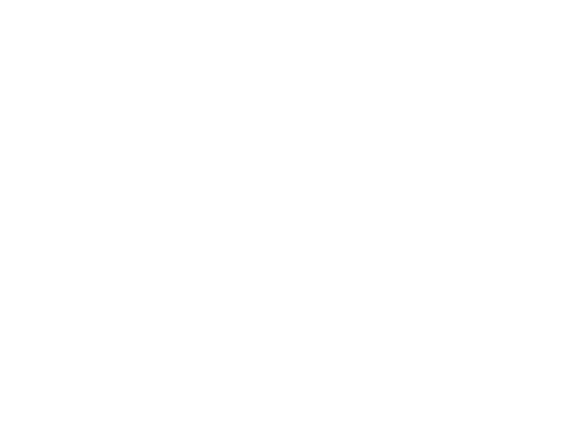

episode rewards: [34.0, 38.0, 16.0, 46.0, 30.0, 18.0, 21.0, 33.0, 47.0, 14.0, 25.0, 24.0, 23.0, 26.0, 14.0, 17.0, 15.0, 10.0, 36.0, 18.0, 43.0, 39.0, 44.0, 48.0, 13.0, 28.0, 24.0, 25.0, 18.0, 43.0, 19.0, 39.0, 10.0, 47.0, 26.0, 14.0, 32.0, 26.0, 28.0, 23.0, 20.0, 12.0, 23.0, 8.0, 26.0, 17.0, 24.0, 14.0, 29.0, 17.0] (mean = 25.68)


2021-08-25 21:51:46,359	INFO services.py:1272 -- View the Ray dashboard at http://127.0.0.1:8265
2021-08-25 21:51:50,072	WARNING util.py:53 -- Install gputil for GPU system monitoring.
2021-08-25 21:51:52,859	WARNING util.py:53 -- Install gputil for GPU system monitoring.


<IPython.core.display.Javascript object>


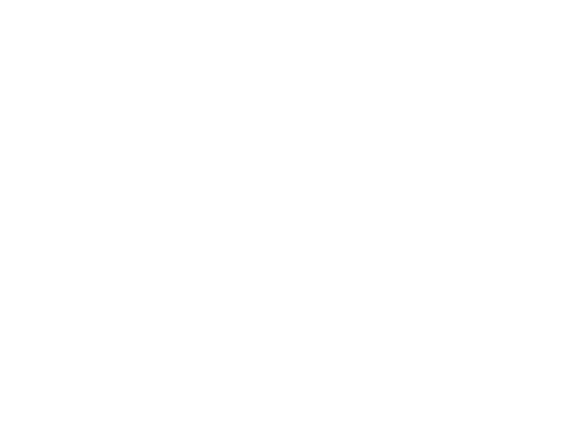

episode rewards: [91.0, 82.0, 90.0, 87.0, 92.0, 81.0, 90.0, 90.0, 87.0, 91.0, 89.0, 91.0, 84.0, 92.0, 86.0, 90.0, 90.0, 91.0, 90.0, 90.0, 90.0, 89.0, 92.0, 92.0, 92.0, 87.0, 91.0, 91.0, 90.0, 89.0, 91.0, 92.0, 87.0, 91.0, 90.0, 88.0, 90.0, 88.0, 89.0, 91.0, 90.0, 91.0, 91.0, 86.0, 90.0, 84.0, 89.0, 87.0, 89.0, 90.0] (mean = 89.22)


2021-08-25 21:52:11,174	INFO services.py:1272 -- View the Ray dashboard at http://127.0.0.1:8265
2021-08-25 21:52:15,188	WARNING util.py:53 -- Install gputil for GPU system monitoring.
2021-08-25 21:52:17,958	WARNING util.py:53 -- Install gputil for GPU system monitoring.


<IPython.core.display.Javascript object>


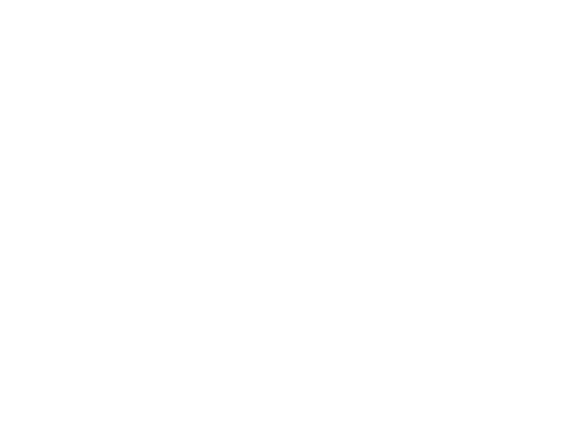

episode rewards: [92.0, 92.0, 93.0, 90.0, 62.0, 75.0, 91.0, 89.0, 85.0, 83.0, 91.0, 91.0, 88.0, 91.0, 91.0, 89.0, 94.75, 74.0, 90.0, 92.0, 72.0, 92.0, 87.0, 94.75, 92.0, 86.0, 89.0, 87.0, 91.0, 81.0, 87.0, 95.5, 87.0, 91.0, 87.0, 92.0, 79.0, 89.0, 86.0, 92.0, 90.0, 91.0, 50.0, 91.0, 90.0, 91.0, 85.0, 85.0, 80.0, 76.0] (mean = 86.6)


2021-08-25 21:52:37,004	INFO services.py:1272 -- View the Ray dashboard at http://127.0.0.1:8265
2021-08-25 21:52:40,875	WARNING util.py:53 -- Install gputil for GPU system monitoring.
2021-08-25 21:52:43,658	WARNING util.py:53 -- Install gputil for GPU system monitoring.


<IPython.core.display.Javascript object>


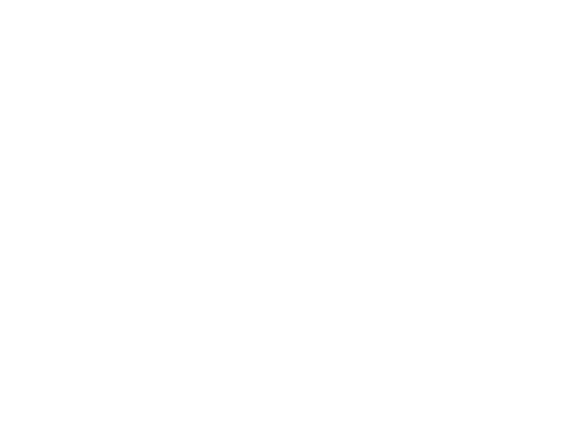

episode rewards: [13.0, 14.0, 10.0, 18.0, 21.0, 15.0, 17.0, 21.0, 14.0, 18.0, 17.0, 14.0, 17.0, 13.0, 14.0, 15.0, 20.0, 10.0, 19.0, 14.0, 12.0, 15.0, 31.0, 15.0, 15.0, 18.0, 16.0, 15.0, 26.0, 17.0, 24.0, 11.0, 16.0, 18.0, 14.0, 16.0, 43.0, 14.0, 15.0, 16.0, 23.0, 12.0, 16.0, 27.0, 19.0, 21.0, 26.0, 16.0, 22.0, 14.0] (mean = 17.54)


In [9]:
run_name_0 = "simple123"
run_name_1 = "simple456"
config_name = "simple_2"
heterogeneous = True
max_checkpoint = 501
num_episodes = 50
random_start = False

config = load_config(config_name)
config["env_config"]["random_start"] = random_start
self_play_mean_reward_2_0 = []
self_play_mean_reward_2_1 = []
cross_play_mean_reward_2 = []
all_checkpoints = list(range(1, max_checkpoint + 1, 25))
for checkpoint in all_checkpoints:
    sp_0, sp_1, cp = cross_play(
        run_name_0, run_name_1, checkpoint, checkpoint, config,
        heterogeneous=heterogeneous, num_episodes=num_episodes
    )
    self_play_mean_reward_2_0.append(sum(sp_0) / num_episodes)
    self_play_mean_reward_2_1.append(sum(sp_1) / num_episodes)
    cross_play_mean_reward_2.append(sum(cp) / num_episodes)

In [ ]:
run_name_0 = "simple_4_123"
run_name_1 = "simple_4_456"
config_name = "simple_4"
heterogeneous = True
max_checkpoint = 501
num_episodes = 50
random_start = False

config = load_config(config_name)
config["env_config"]["random_start"] = random_start
self_play_mean_reward_4_0 = []
self_play_mean_reward_4_1 = []
cross_play_mean_reward_4 = []
all_checkpoints = list(range(1, max_checkpoint + 1, 25))
for checkpoint in all_checkpoints:
    sp_0, sp_1, cp = cross_play(
        run_name_0, run_name_1, checkpoint, checkpoint, config,
        heterogeneous=heterogeneous, num_episodes=num_episodes
    )
    self_play_mean_reward_4_0.append(sum(sp_0) / num_episodes)
    self_play_mean_reward_4_1.append(sum(sp_1) / num_episodes)
    cross_play_mean_reward_4.append(sum(cp) / num_episodes)

2021-08-25 22:24:52,978	INFO services.py:1272 -- View the Ray dashboard at http://127.0.0.1:8265
2021-08-25 22:24:56,758	WARNING util.py:53 -- Install gputil for GPU system monitoring.
2021-08-25 22:24:59,526	WARNING util.py:53 -- Install gputil for GPU system monitoring.
2021-08-25 22:25:02,335	WARNING util.py:53 -- Install gputil for GPU system monitoring.
2021-08-25 22:25:04,946	WARNING util.py:53 -- Install gputil for GPU system monitoring.


episode rewards: [56.0, 46.0, 59.0, 61.0, 68.0, 52.0, 48.0, 61.0, 63.0, 50.0, 50.0, 42.0, 55.0, 50.0, 63.0, 52.0, 54.0, 56.0, 45.0, 48.0, 56.0, 46.0, 49.0, 67.0, 59.0, 34.0, 58.0, 70.0, 51.0, 55.0, 70.0, 34.0, 55.0, 55.0, 43.0, 45.0, 56.0, 40.0, 38.0, 53.0, 48.0, 69.0, 61.0, 42.0, 54.0, 59.0, 51.0, 73.0, 70.0, 58.0] (mean = 53.96)


2021-08-25 22:25:33,692	INFO services.py:1272 -- View the Ray dashboard at http://127.0.0.1:8265
2021-08-25 22:25:37,504	WARNING util.py:53 -- Install gputil for GPU system monitoring.
2021-08-25 22:25:40,339	WARNING util.py:53 -- Install gputil for GPU system monitoring.
2021-08-25 22:25:43,228	WARNING util.py:53 -- Install gputil for GPU system monitoring.
2021-08-25 22:25:45,899	WARNING util.py:53 -- Install gputil for GPU system monitoring.


episode rewards: [53.0, 47.0, 53.0, 71.0, 67.0, 64.0, 63.0, 61.0, 56.0, 54.0, 53.0, 49.0, 63.0, 77.0, 57.0, 60.0, 65.0, 60.0, 50.0, 68.0, 51.0, 72.0, 55.0, 53.0, 60.0, 61.0, 64.0, 50.0, 46.0, 57.0, 66.0, 60.0, 63.0, 60.0, 47.0, 48.0, 61.0, 51.0, 53.0, 68.0, 68.0, 61.0, 47.0, 62.0, 57.0, 68.0, 63.0, 59.0, 66.0, 47.0] (mean = 58.7)


2021-08-25 22:26:12,133	INFO services.py:1272 -- View the Ray dashboard at http://127.0.0.1:8265
2021-08-25 22:26:16,038	WARNING util.py:53 -- Install gputil for GPU system monitoring.
2021-08-25 22:26:18,886	WARNING util.py:53 -- Install gputil for GPU system monitoring.
2021-08-25 22:26:21,694	WARNING util.py:53 -- Install gputil for GPU system monitoring.
2021-08-25 22:26:24,571	WARNING util.py:53 -- Install gputil for GPU system monitoring.


episode rewards: [48.0, 48.0, 50.0, 70.0, 60.0, 70.0, 69.0, 34.0, 62.0, 69.0, 46.0, 42.0, 38.0, 61.0, 55.0, 57.0, 49.0, 74.0, 56.0, 57.0, 69.0, 63.0, 48.0, 61.0, 48.0, 58.0, 52.0, 48.0, 44.0, 51.0, 58.0, 58.0, 61.0, 51.0, 47.0, 64.0, 63.0, 41.0, 61.0, 47.0, 58.0, 67.0, 66.0, 45.0, 45.0, 62.0, 50.0, 79.0, 50.0, 36.0] (mean = 55.32)


2021-08-25 22:26:54,358	INFO services.py:1272 -- View the Ray dashboard at http://127.0.0.1:8265
2021-08-25 22:26:58,163	WARNING util.py:53 -- Install gputil for GPU system monitoring.
2021-08-25 22:27:01,053	WARNING util.py:53 -- Install gputil for GPU system monitoring.
2021-08-25 22:27:03,923	WARNING util.py:53 -- Install gputil for GPU system monitoring.
2021-08-25 22:27:06,722	WARNING util.py:53 -- Install gputil for GPU system monitoring.


episode rewards: [70.0, 52.0, 47.0, 46.0, 64.0, 38.0, 52.0, 69.0, 62.0, 50.0, 65.0, 60.0, 56.0, 62.0, 48.0, 75.0, 59.0, 60.0, 66.0, 58.0, 69.0, 77.0, 63.0, 71.0, 57.0, 62.0, 60.0, 64.0, 67.0, 55.0, 47.0, 44.0, 47.0, 70.0, 66.0, 61.0, 60.0, 64.0, 69.0, 58.0, 48.0, 52.0, 69.0, 66.0, 42.0, 83.0, 65.0, 43.0, 62.0, 70.0] (mean = 59.8)


2021-08-25 22:27:35,454	INFO services.py:1272 -- View the Ray dashboard at http://127.0.0.1:8265
2021-08-25 22:27:39,178	WARNING util.py:53 -- Install gputil for GPU system monitoring.
2021-08-25 22:27:41,919	WARNING util.py:53 -- Install gputil for GPU system monitoring.
2021-08-25 22:27:44,668	WARNING util.py:53 -- Install gputil for GPU system monitoring.
2021-08-25 22:27:47,437	WARNING util.py:53 -- Install gputil for GPU system monitoring.


episode rewards: [63.0, 56.0, 57.0, 58.0, 55.0, 71.0, 58.0, 44.0, 67.0, 55.0, 44.0, 67.0, 46.0, 66.0, 47.0, 68.0, 69.0, 56.0, 57.0, 57.0, 67.0, 65.0, 64.0, 46.0, 68.0, 54.0, 72.0, 67.0, 59.0, 54.0, 53.0, 65.0, 51.0, 79.0, 57.0, 52.0, 72.0, 57.0, 67.0, 51.0, 69.0, 43.0, 70.0, 73.0, 53.0, 50.0, 64.0, 58.0, 59.0, 61.0] (mean = 59.62)


2021-08-25 22:28:16,344	INFO services.py:1272 -- View the Ray dashboard at http://127.0.0.1:8265
2021-08-25 22:28:20,189	WARNING util.py:53 -- Install gputil for GPU system monitoring.
2021-08-25 22:28:22,929	WARNING util.py:53 -- Install gputil for GPU system monitoring.
2021-08-25 22:28:25,829	WARNING util.py:53 -- Install gputil for GPU system monitoring.
2021-08-25 22:28:28,923	WARNING util.py:53 -- Install gputil for GPU system monitoring.


episode rewards: [47.0, 60.0, 74.0, 59.0, 53.0, 66.0, 58.0, 64.0, 59.0, 50.0, 21.0, 55.0, 59.0, 57.0, 66.0, 36.0, 42.0, 49.0, 45.0, 46.0, 40.0, 36.0, 53.0, 49.0, 55.0, 46.0, 36.0, 57.0, 57.0, 55.0, 35.0, 60.0, 55.0, 42.0, 54.0, 54.0, 64.0, 59.0, 57.0, 42.0, 44.0, 49.0, 57.0, 42.0, 39.0, 43.0, 56.0, 61.0, 56.0, 57.0] (mean = 51.52)


2021-08-25 22:28:58,836	INFO services.py:1272 -- View the Ray dashboard at http://127.0.0.1:8265
2021-08-25 22:29:02,657	WARNING util.py:53 -- Install gputil for GPU system monitoring.
2021-08-25 22:29:05,391	WARNING util.py:53 -- Install gputil for GPU system monitoring.
2021-08-25 22:29:08,133	WARNING util.py:53 -- Install gputil for GPU system monitoring.
2021-08-25 22:29:10,871	WARNING util.py:53 -- Install gputil for GPU system monitoring.


episode rewards: [62.0, 50.0, 51.0, 52.0, 51.0, 52.0, 60.0, 61.0, 60.0, 50.0, 56.0, 57.0, 58.0, 58.0, 68.0, 51.0, 71.0, 46.0, 54.0, 44.0, 66.0, 61.0, 59.0, 50.0, 55.0, 41.0, 64.0, 36.0, 49.0, 56.0, 68.0, 52.0, 56.0, 68.0, 43.0, 50.0, 54.0, 68.0, 61.0, 65.0, 56.0, 76.0, 74.0, 55.0, 67.0, 54.0, 68.0, 67.0, 60.0, 60.0] (mean = 57.42)


2021-08-25 22:29:39,740	INFO services.py:1272 -- View the Ray dashboard at http://127.0.0.1:8265
2021-08-25 22:29:43,519	WARNING util.py:53 -- Install gputil for GPU system monitoring.
2021-08-25 22:29:46,288	WARNING util.py:53 -- Install gputil for GPU system monitoring.
2021-08-25 22:29:49,022	WARNING util.py:53 -- Install gputil for GPU system monitoring.
2021-08-25 22:29:51,775	WARNING util.py:53 -- Install gputil for GPU system monitoring.


episode rewards: [57.0, 45.0, 55.0, 55.0, 71.0, 76.0, 43.0, 66.0, 50.0, 65.0, 68.0, 66.0, 68.0, 57.0, 61.0, 64.0, 65.0, 56.0, 66.0, 44.0, 56.0, 54.0, 67.0, 71.0, 52.0, 57.0, 67.0, 70.0, 57.0, 72.0, 56.0, 61.0, 74.0, 66.0, 59.0, 69.0, 61.0, 63.0, 45.0, 56.0, 64.0, 65.0, 57.0, 70.0, 67.0, 75.0, 62.0, 60.0, 40.0, 57.0] (mean = 60.96)


2021-08-25 22:30:20,619	INFO services.py:1272 -- View the Ray dashboard at http://127.0.0.1:8265
2021-08-25 22:30:24,423	WARNING util.py:53 -- Install gputil for GPU system monitoring.
2021-08-25 22:30:27,141	WARNING util.py:53 -- Install gputil for GPU system monitoring.
2021-08-25 22:30:29,886	WARNING util.py:53 -- Install gputil for GPU system monitoring.
2021-08-25 22:30:32,607	WARNING util.py:53 -- Install gputil for GPU system monitoring.


episode rewards: [57.0, 19.0, 50.0, 27.0, 57.0, 49.0, 59.0, 23.0, 45.0, 65.0, 72.0, 66.0, 55.0, 24.0, 53.0, 45.0, 45.0, 54.0, 61.0, 42.0, 66.0, 49.0, 55.0, 20.0, 41.0, 53.0, 32.0, 67.0, 60.0, 29.0, 57.0, 58.0, 57.0, 73.0, 51.0, 43.0, 30.0, 42.0, 54.0, 58.0, 55.0, 48.0, 47.0, 63.0, 44.0, 21.0, 61.0, 50.0, 34.0, 55.0] (mean = 48.82)


2021-08-25 22:31:00,902	INFO services.py:1272 -- View the Ray dashboard at http://127.0.0.1:8265
2021-08-25 22:31:04,636	WARNING util.py:53 -- Install gputil for GPU system monitoring.
2021-08-25 22:31:07,368	WARNING util.py:53 -- Install gputil for GPU system monitoring.
2021-08-25 22:31:10,091	WARNING util.py:53 -- Install gputil for GPU system monitoring.
2021-08-25 22:31:12,831	WARNING util.py:53 -- Install gputil for GPU system monitoring.


episode rewards: [41.0, 55.0, 47.0, 75.0, 68.0, 57.0, 73.0, 70.0, 56.0, 64.0, 75.0, 62.0, 61.0, 56.0, 58.0, 63.0, 68.0, 65.0, 53.0, 53.0, 57.0, 64.0, 63.0, 68.0, 61.0, 78.0, 73.0, 69.0, 65.0, 66.0, 53.0, 73.0, 45.0, 45.0, 68.0, 56.0, 68.0, 50.0, 66.0, 58.0, 56.0, 49.0, 60.0, 67.0, 68.0, 68.0, 65.0, 61.0, 66.0, 44.0] (mean = 61.4)


2021-08-25 22:31:40,683	INFO services.py:1272 -- View the Ray dashboard at http://127.0.0.1:8265
2021-08-25 22:31:44,460	WARNING util.py:53 -- Install gputil for GPU system monitoring.
2021-08-25 22:31:47,187	WARNING util.py:53 -- Install gputil for GPU system monitoring.
2021-08-25 22:31:49,895	WARNING util.py:53 -- Install gputil for GPU system monitoring.
2021-08-25 22:31:52,592	WARNING util.py:53 -- Install gputil for GPU system monitoring.


episode rewards: [68.0, 56.0, 61.0, 52.0, 60.0, 37.0, 43.0, 59.0, 60.0, 58.0, 65.0, 56.0, 69.0, 56.0, 76.0, 71.0, 57.0, 53.0, 44.0, 69.0, 69.0, 69.0, 66.0, 82.0, 63.0, 65.0, 68.0, 68.0, 74.0, 63.0, 59.0, 69.0, 54.0, 55.0, 73.0, 57.0, 72.0, 58.0, 42.0, 68.0, 43.0, 72.0, 58.0, 70.0, 50.0, 66.0, 43.0, 48.0, 61.0, 66.0] (mean = 60.82)


2021-08-25 22:32:20,405	INFO services.py:1272 -- View the Ray dashboard at http://127.0.0.1:8265
2021-08-25 22:32:24,174	WARNING util.py:53 -- Install gputil for GPU system monitoring.
2021-08-25 22:32:26,971	WARNING util.py:53 -- Install gputil for GPU system monitoring.
2021-08-25 22:32:30,019	WARNING util.py:53 -- Install gputil for GPU system monitoring.
2021-08-25 22:32:32,741	WARNING util.py:53 -- Install gputil for GPU system monitoring.


episode rewards: [47.0, 53.0, 62.0, 66.0, 51.0, 55.0, 56.0, 62.0, 38.0, 64.0, 53.0, 56.0, 64.0, 66.0, 56.0, 55.0, 35.0, 40.0, 44.0, 49.0, 41.0, 40.0, 68.0, 63.0, 69.0, 56.0, 59.0, 44.0, 74.0, 64.0, 49.0, 68.0, 47.0, 66.0, 46.0, 52.0, 40.0, 69.0, 41.0, 49.0, 49.0, 41.0, 62.0, 59.0, 37.0, 76.0, 54.0, 52.0, 57.0, 65.0] (mean = 54.58)


2021-08-25 22:33:02,409	INFO services.py:1272 -- View the Ray dashboard at http://127.0.0.1:8265
2021-08-25 22:33:06,155	WARNING util.py:53 -- Install gputil for GPU system monitoring.
2021-08-25 22:33:08,882	WARNING util.py:53 -- Install gputil for GPU system monitoring.
2021-08-25 22:33:11,594	WARNING util.py:53 -- Install gputil for GPU system monitoring.
2021-08-25 22:33:14,317	WARNING util.py:53 -- Install gputil for GPU system monitoring.


episode rewards: [56.0, 53.0, 48.0, 63.0, 52.0, 63.0, 45.0, 46.0, 69.0, 59.0, 53.0, 67.0, 49.0, 61.0, 69.0, 63.0, 58.0, 56.0, 73.0, 76.0, 52.0, 76.0, 72.0, 52.0, 62.0, 70.0, 54.0, 68.0, 65.0, 57.0, 48.0, 76.0, 57.0, 55.0, 51.0, 66.0, 57.0, 67.0, 58.0, 52.0, 77.0, 63.0, 66.0, 36.0, 73.0, 45.0, 58.0, 75.0, 72.0, 52.0] (mean = 60.22)


2021-08-25 22:33:43,176	INFO services.py:1272 -- View the Ray dashboard at http://127.0.0.1:8265
2021-08-25 22:33:46,889	WARNING util.py:53 -- Install gputil for GPU system monitoring.
2021-08-25 22:33:49,558	WARNING util.py:53 -- Install gputil for GPU system monitoring.
2021-08-25 22:33:52,175	WARNING util.py:53 -- Install gputil for GPU system monitoring.
2021-08-25 22:33:54,877	WARNING util.py:53 -- Install gputil for GPU system monitoring.


episode rewards: [67.0, 69.0, 63.0, 68.0, 57.0, 66.0, 63.0, 70.0, 71.0, 73.0, 70.0, 73.0, 67.0, 58.0, 81.0, 60.0, 63.0, 76.0, 75.0, 71.0, 60.0, 55.0, 80.0, 43.0, 81.0, 73.0, 44.0, 74.0, 65.0, 66.0, 66.0, 70.0, 58.0, 70.0, 70.0, 68.0, 69.0, 71.0, 40.0, 66.0, 45.0, 57.0, 78.0, 67.0, 70.0, 77.0, 55.0, 58.0, 72.0, 65.0] (mean = 65.88)


2021-08-25 22:34:23,296	INFO services.py:1272 -- View the Ray dashboard at http://127.0.0.1:8265
2021-08-25 22:34:26,948	WARNING util.py:53 -- Install gputil for GPU system monitoring.
2021-08-25 22:34:29,586	WARNING util.py:53 -- Install gputil for GPU system monitoring.
2021-08-25 22:34:32,233	WARNING util.py:53 -- Install gputil for GPU system monitoring.
2021-08-25 22:34:34,902	WARNING util.py:53 -- Install gputil for GPU system monitoring.


episode rewards: [33.0, 65.0, 34.0, 57.0, 64.0, 55.0, 52.0, 34.0, 32.0, 57.0, 56.0, 62.0, 46.0, 69.0, 53.0, 35.0, 50.0, 42.0, 53.0, 74.0, 38.0, 44.0, 38.0, 49.0, 49.0, 49.0, 55.0, 54.0, 45.0, 38.0, 33.0, 61.0, 61.0, 40.0, 63.0, 39.0, 48.0, 51.0, 63.0, 44.0, 49.0, 42.0, 54.0, 39.0, 47.0, 16.0, 40.0, 62.0, 47.0, 41.0] (mean = 48.44)


2021-08-25 22:35:02,532	INFO services.py:1272 -- View the Ray dashboard at http://127.0.0.1:8265
2021-08-25 22:35:06,559	WARNING util.py:53 -- Install gputil for GPU system monitoring.
2021-08-25 22:35:09,389	WARNING util.py:53 -- Install gputil for GPU system monitoring.
2021-08-25 22:35:12,219	WARNING util.py:53 -- Install gputil for GPU system monitoring.
2021-08-25 22:35:15,143	WARNING util.py:53 -- Install gputil for GPU system monitoring.


episode rewards: [61.0, 60.0, 59.0, 56.0, 63.0, 54.0, 49.0, 44.0, 78.0, 58.0, 53.0, 54.0, 50.0, 64.0, 70.0, 76.0, 78.0, 69.0, 59.0, 54.0, 61.0, 68.0, 64.0, 71.0, 59.0, 63.0, 63.0, 54.0, 73.0, 59.0, 71.0, 62.0, 77.0, 56.0, 48.0, 71.0, 62.0, 46.0, 65.0, 67.0, 53.0, 68.0, 69.0, 71.0, 60.0, 42.0, 63.0, 75.0, 74.0, 61.0] (mean = 62.1)


2021-08-25 22:35:44,571	INFO services.py:1272 -- View the Ray dashboard at http://127.0.0.1:8265
2021-08-25 22:35:48,500	WARNING util.py:53 -- Install gputil for GPU system monitoring.
2021-08-25 22:35:51,296	WARNING util.py:53 -- Install gputil for GPU system monitoring.
2021-08-25 22:35:54,299	WARNING util.py:53 -- Install gputil for GPU system monitoring.
2021-08-25 22:35:57,025	WARNING util.py:53 -- Install gputil for GPU system monitoring.


episode rewards: [80.0, 69.0, 64.0, 75.0, 57.0, 54.0, 68.0, 73.0, 68.0, 75.0, 45.0, 63.0, 73.0, 64.0, 52.0, 68.0, 45.0, 71.0, 76.0, 61.0, 57.0, 60.0, 65.0, 64.0, 58.0, 43.0, 62.0, 70.0, 63.0, 75.0, 63.0, 72.0, 77.0, 66.0, 72.0, 60.0, 65.0, 63.0, 75.0, 65.0, 80.0, 76.0, 63.0, 44.0, 52.0, 74.0, 63.0, 57.0, 79.0, 54.0] (mean = 64.76)


2021-08-25 22:36:25,560	INFO services.py:1272 -- View the Ray dashboard at http://127.0.0.1:8265
2021-08-25 22:36:29,186	WARNING util.py:53 -- Install gputil for GPU system monitoring.
2021-08-25 22:36:31,771	WARNING util.py:53 -- Install gputil for GPU system monitoring.
2021-08-25 22:36:34,432	WARNING util.py:53 -- Install gputil for GPU system monitoring.
2021-08-25 22:36:37,041	WARNING util.py:53 -- Install gputil for GPU system monitoring.


In [ ]:
run_name_0 = "simple_8_123"
run_name_1 = "simple_8_456"
config_name = "simple_8"
heterogeneous = True
max_checkpoint = 501
num_episodes = 50
random_start = False

config = load_config(config_name)
config["env_config"]["random_start"] = random_start
self_play_mean_reward_8_0 = []
self_play_mean_reward_8_1 = []
cross_play_mean_reward_8 = []
all_checkpoints = list(range(1, max_checkpoint + 1, 25))
for checkpoint in all_checkpoints:
    sp_0, sp_1, cp = cross_play(
        run_name_0, run_name_1, checkpoint, checkpoint, config,
        heterogeneous=heterogeneous, num_episodes=num_episodes
    )
    self_play_mean_reward_8_0.append(sum(sp_0) / num_episodes)
    self_play_mean_reward_8_1.append(sum(sp_1) / num_episodes)
    cross_play_mean_reward_8.append(sum(cp) / num_episodes)

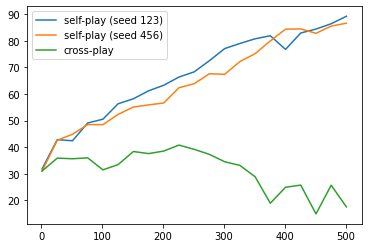

In [28]:
%matplotlib inline
all_checkpoints = list(range(1, 502, 25))
fig = plt.figure()
ax1 = fig.add_subplot(311)
ax1.plot(all_checkpoints, self_play_mean_reward_2_0, label="self-play (seed 123)")
ax1.plot(all_checkpoints, self_play_mean_reward_2_1, label="self-play (seed 456)")
ax1.plot(all_checkpoints, cross_play_mean_reward_2, label="cross-play")
ax2 = fig.add_subplot(312)
ax2.plot(all_checkpoints, self_play_mean_reward_4_0, label="self-play (seed 123)")
ax2.plot(all_checkpoints, self_play_mean_reward_4_1, label="self-play (seed 456)")
ax2.plot(all_checkpoints, cross_play_mean_reward_4, label="cross-play")
ax3 = fig.add_subplot(313)
ax3.plot(all_checkpoints, self_play_mean_reward_8_0, label="self-play (seed 123)")
ax3.plot(all_checkpoints, self_play_mean_reward_8_1, label="self-play (seed 456)")
ax3.plot(all_checkpoints, cross_play_mean_reward_8, label="cross-play")
plt.legend()